# 1 e- ROI & 0nubb -- Info for different pressures

13'5, 5, 2 and 1 bar plots for 1eroi and 0nubb data:
* nexus: number of hits, energy distribution, efficiencies...
* label:
    * hits:   number of hits, energy distribution... separated by segclass (both hit by hit and grouping the segclass info per event)
    * voxels: number of hits, energy distribution... separated by segclass (both voxel by voxel and grouping the segclass info per event)
* separation stats: # of separated, interrupted tracks...


## INTRO CELLS

In [1]:
import sys
import glob
import numpy as np
import tables as tb
import pandas as pd

from invisible_cities.io.dst_io import load_dst
import matplotlib.pyplot as plt

sys.path.append('/home/usc/ie/mpm/data_labelling')


In [2]:
basedir = '/mnt/lustre/scratch/nlsas/home/usc/ie/mpm/NEXT100/data/pressure_topology/'

pressures = ['1bar', '2bar', '5bar', '13bar', '20bar']

In [3]:
def get_file_dict(basedir, dt, pressures = ['1bar', '2bar', '5bar', '13bar', '20bar']):
    nexusfiles, labelfiles, graphfiles = {}, {}, {}

    for p in pressures:
        nexusdir = basedir + '{p}/{dt}/nexus/*_{dt}.h5'.format(p = p, dt = dt)
        labeldir = basedir + '{p}/{dt}/label/prod/*_{dt}.h5'.format(p = p, dt = dt)
        graphdir = basedir + '{p}/{dt}/label/prod/*_{dt}_graph.h5'.format(p = p, dt = dt)

        nexusfiles[p] = sorted(glob.glob(nexusdir), key = lambda x: int(x.split('/')[-1].split('_')[-2]))
        labelfiles[p] = sorted(glob.glob(labeldir), key = lambda x: int(x.split('/')[-1].split('_')[-2]))
        graphfiles[p] = sorted(glob.glob(graphdir), key = lambda x: int(x.split('/')[-1].split('_')[-3]))
    return nexusfiles, labelfiles, graphfiles

In [4]:
# basedir = '/mnt/lustre/scratch/nlsas/home/usc/ie/mpm/NEXT100/data/pressure_topology/'
# pressures = ['1bar', '2bar', '5bar', '13bar']
# data_type = ['0nubb', '1eroi']

# nexusfiles, labelfiles, graphfiles = {}, {}, {}

# for dt in data_type:
#     for p in pressures:
#         nexusdir = basedir + '{p}/{dt}/nexus/*_{dt}.h5'.format(p = p, dt = dt)
#         labeldir = basedir + '{p}/{dt}/label/prod/*_{dt}.h5'.format(p = p, dt = dt)
#         graphdir = basedir + '{p}/{dt}/label/prod/*_{dt}_graph.h5'.format(p = p, dt = dt)

#         nexusfiles[p + '/' + dt] = sorted(glob.glob(nexusdir), key = lambda x: int(x.split('/')[-1].split('_')[-2]))
#         labelfiles[p + '/' + dt] = sorted(glob.glob(labeldir), key = lambda x: int(x.split('/')[-1].split('_')[-2]))
#         graphfiles[p + '/' + dt] = sorted(glob.glob(graphdir), key = lambda x: int(x.split('/')[-1].split('_')[-3]))

In [5]:
import matplotlib as mpl
from   mpl_toolkits.mplot3d import Axes3D

def plot_3d_hits(event, value, coords = ['x', 'y', 'z'], cmap = mpl.cm.jet, rotate = None):
    xcoord  = event[coords[0]].values
    ycoord  = event[coords[1]].values
    zcoord  = event[coords[2]].values
    content = event[value].values

    fig  = plt.figure(figsize=(8, 8), frameon=False)
    gs   = fig.add_gridspec(12, 12)
    ax   = fig.add_subplot(gs[0:12, 0:10], projection = '3d')
    axcb = fig.add_subplot(gs[1:11, 11])
    norm = mpl.colors.Normalize(vmin=0, vmax=max(content))

    m    = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

    colors = np.asarray(np.vectorize(m.to_rgba)(content))
    colors = np.rollaxis(colors, 0, 2)

    ax.scatter(xcoord, ycoord, zcoord, c=colors, marker='o')
    cb = mpl.colorbar.ColorbarBase(axcb, cmap=cmap, norm=norm, orientation='vertical')


    ax.set_xlabel('X ')
    ax.set_ylabel('Y ')
    ax.set_zlabel('Z ')
    if rotate: ax.view_init(elev=rotate[0], azim=rotate[1])
    cb.set_label (value, size = 15)
    cb.ax.tick_params(labelsize=13)
    cb.formatter.set_powerlimits((0, 0))
    plt.show()


def voxel_position(bins_info, coord, voxel):
    min_, max_, size_ = bins_info['min_' + coord].values, bins_info['max_' + coord].values, bins_info['size_' + coord].values
    bins = np.arange(min_, max_ + size_ , size_ )
    return bins[voxel]

def plot_label_creator(min_vals, max_vals, voxel_size, bins_info, affluence, coords, real_position = True):
    '''
    Function to create ticks and its labels to plot an event.

    Args:
        min_vals: TUPLE
    Contains the minimum values for each coordinate of the position of all the voxels in an event.

        max_vals: TUPLE
    Contains the maximum values for each coordinate of the position of all the voxels in an event.

        voxel_size: TUPLE
    Contains the voxel size of the detector for each coordinate. Used to create the labels.

        affluence: TUPLE
    Separation parameter for the labels in each coordinate. If 1, labels will be plotted for each voxel step,
    if 2, they will be plotted each 2 voxel steps, etc.

    RETURNS:
        labels: LIST
    List of arrays (one per coord.) with the labels we want to use (those consistent with the voxel size in
    each coordinate).

        ticks: LIST
    List of arrays (one per coord.) with the ticks that we want to label.
    '''
    labels = []
    ticks  = []
    for mini, maxi, size, aff in zip(min_vals, max_vals, voxel_size, affluence):
        ticks.append(np.arange(0, maxi - mini + 2, aff))

    if real_position:
        min_vals = voxel_position(bins_info, coords[0], min_vals[0]), voxel_position(bins_info, coords[1], min_vals[1]), voxel_position(bins_info, coords[2], min_vals[2])
        max_vals = voxel_position(bins_info, coords[0], max_vals[0]), voxel_position(bins_info, coords[1], max_vals[1]), voxel_position(bins_info, coords[2], max_vals[2])
        #voxel_size = (1, 1, 1)

        for mini, maxi, size, aff in zip(min_vals, max_vals, voxel_size, affluence):
            labels.append(np.arange(mini, (maxi + 2) , size * aff))
    
    if not real_position:
            for mini, maxi, size, aff in zip(min_vals, max_vals, voxel_size, affluence):
                labels.append(np.arange(mini * size, (maxi + 2) * size, size * aff))
    return labels, ticks


def plot_3d_vox(event, voxel_size, value, bins_info, coords = ['x', 'y', 'z'], affluence = (5, 5, 5), real_position = True, th=0, edgecolor='k', linewidth = .3, cmap=mpl.cm.jet, opacity = 1, rotate = None):
    '''
    Function to plot voxels (they have to be normalized)
    Args:
        hits_digitized: DataFrame or list/tuple/array of lists/tuples/arrays in any combination
    Contains the spatial information of the voxels and their content. If we don't use a DataFrame, the input
    must have the structure (x, y, z, content), where content is usually the energy or the segclass. Its shape
    will be (4, N).
        value: STR
    Name of the content column in the DataFrame. Will be also the label of the colorbar.
        coords: LIST
    Name of the coords column in the DataFrame.
        th: FLOAT
    Low threshold of the content of the voxels to plot.
        edgecolor: STR
    Color of the edges of the voxels.
        linewidth: FLOAT
    Width of the edges of the voxels.
        cmap: matplotlib.cm
    Used colormap.
        opacity = FLOAT
    Value from 0 to 1 that indicates the opacity of the voxels.
    '''

    xcoord  = event[coords[0]].values
    ycoord  = event[coords[1]].values
    zcoord  = event[coords[2]].values
    content = event[value].values

    xmin, xmax = min(xcoord), max(xcoord)
    ymin, ymax = min(ycoord), max(ycoord)
    zmin, zmax = min(zcoord), max(zcoord)

    labels, ticks = plot_label_creator((xmin, ymin, zmin), (xmax, ymax, zmax), voxel_size, bins_info, affluence, coords, real_position=real_position)

    nbinsX = int(np.ceil((xmax-xmin))) + 2
    nbinsY = int(np.ceil((ymax-ymin))) + 2
    nbinsZ = int(np.ceil((zmax-zmin))) + 2
    xarr = np.ones(shape=(nbinsX, nbinsY, nbinsZ))*th

    nonzeros = np.vstack([xcoord-xmin+1,
                          ycoord-ymin+1,
                          zcoord-zmin+1])

    nonzeros = nonzeros.astype(int)
    xarr[tuple(nonzeros)] = content
    voxels  = xarr > th

    fig  = plt.figure(figsize=(8, 8), frameon=False)
    gs   = fig.add_gridspec(12, 12)
    ax   = fig.add_subplot(gs[0:12, 0:10], projection = '3d')
    axcb = fig.add_subplot(gs[1:11, 11])
    norm = mpl.colors.Normalize(vmin=xarr.min(), vmax=xarr.max())
    m    = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

    colors = np.asarray(np.vectorize(m.to_rgba)(xarr))
    colors = np.rollaxis(colors, 0, 4)

    ax.voxels(voxels, facecolors=colors * opacity, edgecolor=edgecolor, linewidth = linewidth)
    cb = mpl.colorbar.ColorbarBase(axcb, cmap=cmap, norm=norm, orientation='vertical')

    ax.set_xlabel('X ')
    ax.set_ylabel('Y ')
    ax.set_zlabel('Z ')
    if rotate: ax.view_init(elev=rotate[0], azim=rotate[1])
    
    if value == 'energy':
        cb_label = 'Energy (MeV)'    
    else:
        cb_label = value
        
    cb.set_label (cb_label)
    #cb.ax.tick_params(labelsize=13)
    cb.formatter.set_powerlimits((0, 0))

    ax.set_xticklabels(labels[0])
    ax.set_xticks(ticks[0])
    ax.set_yticklabels(labels[1])
    ax.set_yticks(ticks[1])
    ax.set_zticklabels(labels[2])
    ax.set_zticks(ticks[2])

    plt.show()

## NEXUS

Number of hits, energy distribution, efficiencies...

In [7]:
def get_nexus_info(file_dict, save_path, dt):
    for p in file_dict:
        print(p)
        for f in file_dict[p]:
            results = []
            fnum = int(f.split('_')[-2])
            hits = pd.read_hdf(f, 'MC/hits')
            hits = hits[hits.label == 'ACTIVE']
            for id, df in hits.groupby('event_id'): results.append([df.count().energy, df.sum().energy, p, id, fnum]) 
            df = pd.DataFrame(results, columns = ['nhits', 'tot_ene', 'pressure', 'event_id', 'filenum'])
            df.to_hdf(save_path, dt, append = True, min_itemsize={'pressure': 5})

In [8]:
save_path = basedir + 'nexus_info_df.h5'

# dt = '1eroi'
# nexusfiles, labelfiles, graphfiles = get_file_dict(basedir, dt)
# results = get_nexus_info(nexusfiles, save_path, dt)

# dt = '0nubb'
# nexusfiles, labelfiles, graphfiles = get_file_dict(basedir, dt)
# results = get_nexus_info(nexusfiles, save_path, dt)

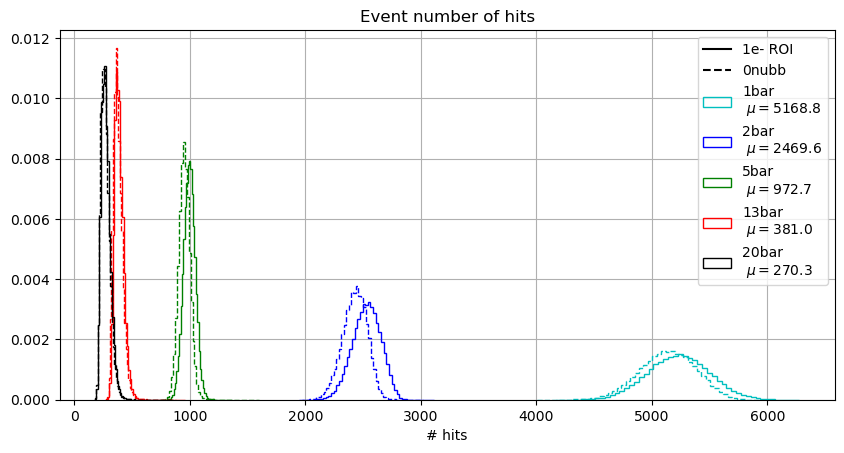

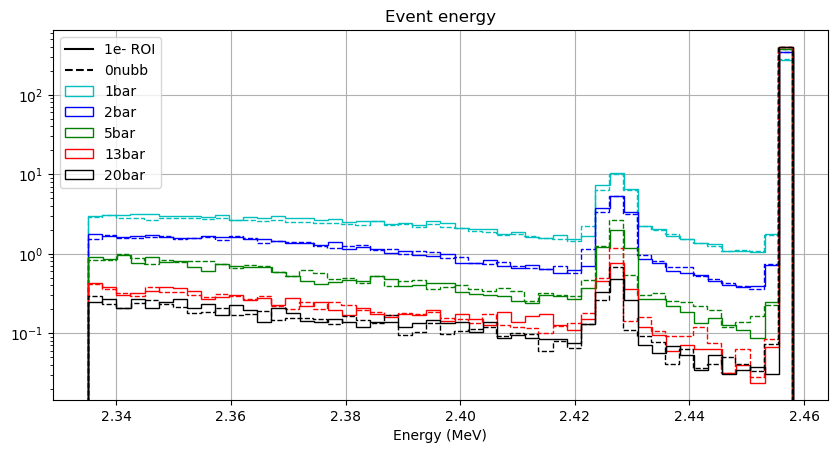

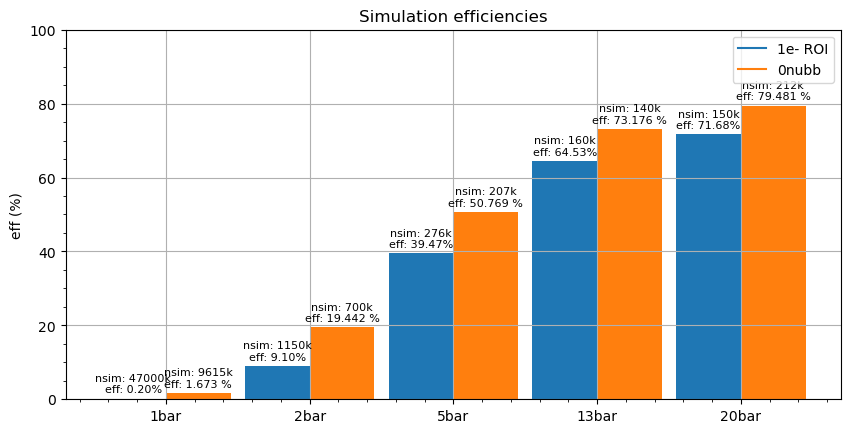

In [55]:
save_path = basedir + 'nexus_info_df.h5'

results_1eroi = pd.read_hdf(save_path, '1eroi')
results_0nubb = pd.read_hdf(save_path, '0nubb')

nsim_per_file_1eroi = {'1bar':23500, '2bar':575, '5bar':138, '13bar':80, '20bar':600}
nsim_per_file_0nubb = {'1bar':3846, '2bar':280, '5bar':830, '13bar':561, '20bar':850} #que me copie los configs pero 5 y 13 estaban bien, lo que 

nfiles_1eroi = {'1bar':2000, '2bar':2000, '5bar':2000, '13bar':2000, '20bar':250}
nfiles_0nubb = {'1bar':2500, '2bar':2500, '5bar':250,  '13bar':250,  '20bar':250}


plot_dict = {'1bar':'c', '2bar':'b', '5bar':'g', '13bar':'r', '20bar':'k'}
bar_width = 0.45

for i, p in enumerate(pressures):
    num_hits_1eroi = results_1eroi[results_1eroi.pressure == p].nhits
    num_hits_0nubb = results_0nubb[results_0nubb.pressure == p].nhits
    mean_nhits = np.append(num_hits_1eroi.values, num_hits_0nubb.values).mean()

    ene_valu_1eroi = results_1eroi[results_1eroi.pressure == p].tot_ene
    ene_valu_0nubb = results_0nubb[results_0nubb.pressure == p].tot_ene

    plt.figure(1, figsize = (10, 4.8))
    plt.hist(num_hits_1eroi, 50, color = plot_dict[p], ls = '-', density = True, histtype = 'step', label=p + '\n $\mu = {:.1f}$'.format(mean_nhits))
    plt.hist(num_hits_0nubb, 50, color = plot_dict[p], ls = '--', density = True, histtype = 'step')
    plt.xlabel('# hits')

    plt.figure(2, figsize = (10, 4.8))
    plt.hist(ene_valu_1eroi, 50, color = plot_dict[p], ls = '-', density = True, histtype= 'step', label=p)
    plt.hist(ene_valu_0nubb, 50, color = plot_dict[p], ls = '--', density = True, histtype= 'step')
    plt.xlabel('Energy (MeV)')

    plt.figure(3, figsize = (10, 4.8))
    eff_1eroi = len(num_hits_1eroi)/(nsim_per_file_1eroi[p] * nfiles_1eroi[p]) * 100
    plt.bar(i - bar_width/2, eff_1eroi, width=bar_width, color='tab:blue')
    plt.text(i - bar_width/2, eff_1eroi + 1, 'nsim: {}k\neff: {:.2f}%'.format(int((nsim_per_file_1eroi[p] * nfiles_1eroi[p])/1000), eff_1eroi),
             ha='center', va='bottom', color='k', fontsize=8)

    eff_0nubb = len(num_hits_0nubb)/(nsim_per_file_0nubb[p] * nfiles_0nubb[p]) * 100
    plt.bar(i + bar_width/2, eff_0nubb, width=bar_width, color='tab:orange')
    plt.text(i + bar_width/2, eff_0nubb + 1, 'nsim: {}k\neff: {:.3f} %'.format(int((nsim_per_file_0nubb[p] * nfiles_0nubb[p])/1000), eff_0nubb),
             ha='center', va='bottom', color='k', fontsize=8)
    plt.ylabel('eff (%)')

plt.figure(1)
plt.plot([], [], 'k-',  label="1e- ROI")
plt.plot([], [], 'k--', label="0nubb")
plt.title('Event number of hits')
plt.grid()
plt.legend()

plt.figure(2)
plt.plot([], [], 'k-',  label="1e- ROI")
plt.plot([], [], 'k--', label="0nubb")
plt.yscale('log')
plt.title('Event energy')
plt.grid()
plt.legend(loc='upper left')

plt.figure(3)
plt.plot([], [], color = 'tab:blue', label="1e- ROI")
plt.plot([], [], color = 'tab:orange', label="0nubb")
plt.legend()
plt.xticks(range(len(pressures)), pressures)
plt.ylim((0, 100))
plt.title('Simulation efficiencies')
plt.minorticks_on()
plt.grid()
#plt.tight_layout()



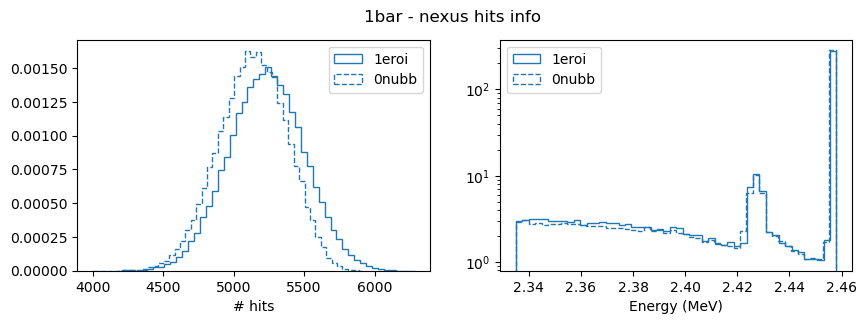

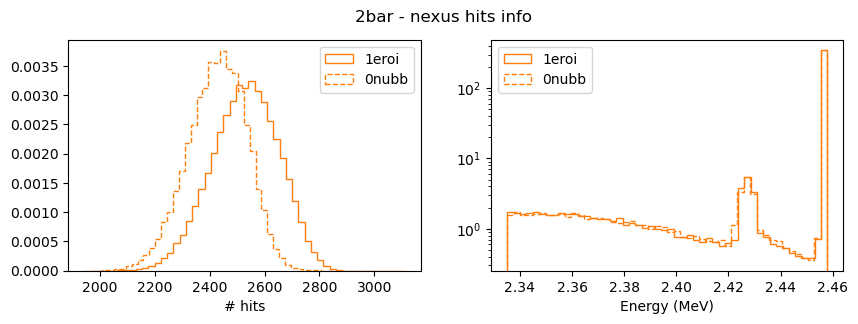

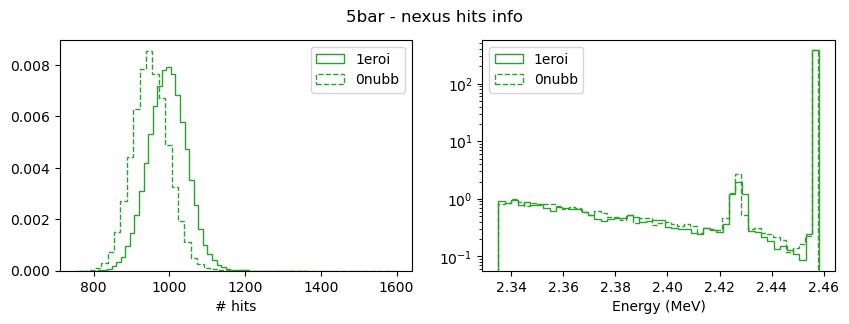

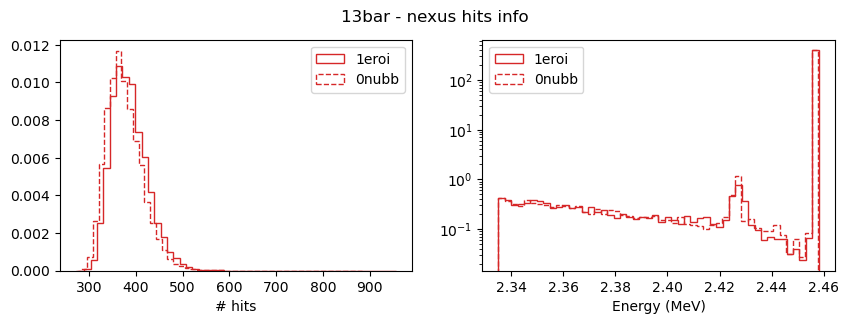

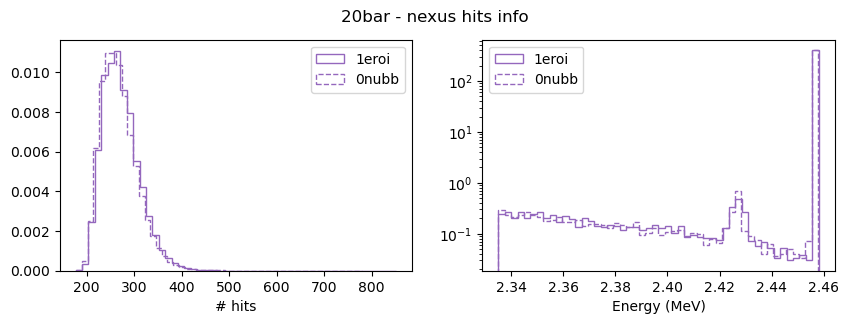

In [20]:
for i, p in enumerate(pressures):
    num_hits_1eroi = results_1eroi[results_1eroi.pressure == p].nhits
    num_hits_0nubb = results_0nubb[results_0nubb.pressure == p].nhits

    ene_valu_1eroi = results_1eroi[results_1eroi.pressure == p].tot_ene
    ene_valu_0nubb = results_0nubb[results_0nubb.pressure == p].tot_ene

    fig = plt.figure(figsize = (10, 3))
    fig.suptitle(p + ' - nexus hits info')
    ax1, ax2 = fig.add_subplot(121), fig.add_subplot(122)
    
    # plt.figure(p + 'nhits', figsize = (10, 4.8))
    ax1.hist(num_hits_1eroi, 50, color = plot_dict[p], ls = '-',  density = True, histtype = 'step', label = '1eroi')
    ax1.hist(num_hits_0nubb, 50, color = plot_dict[p], ls = '--', density = True, histtype = 'step', label = '0nubb')
    # ax1.title(p)
    ax1.set_xlabel('# hits')
    ax1.legend()

    # plt.figure(p + 'ene', figsize = (10, 4.8))
    ax2.hist(ene_valu_1eroi, 50, color = plot_dict[p], ls = '-',  density = True, histtype= 'step', label = '1eroi')
    ax2.hist(ene_valu_0nubb, 50, color = plot_dict[p], ls = '--', density = True, histtype= 'step', label = '0nubb')
    # ax2.title(p)
    ax2.set_yscale('log')
    ax2.set_xlabel('Energy (MeV)')
    ax2.legend(loc='upper left')

1 bar = 94k

2 bar = 2.3k

5 bar = 550

13.5 bar = 320

DIVIDI ESTOS NUMEROS POR 4 PARA TENER 1/4 DE EVENTOS POR FICHERO (SOBRE 50), CON 4 VECES EL NUMERO DE FICHEROS (EN LUGAR DE 500, AHORA SON 2000 FICHEROS)

## LABEL

### Creator functions

In [9]:
def get_all_segclasses(df, names = ['dataset_id', 'segclass'], segclass = [1, 2, 3]):
    '''
    This function is created in order to have a 0 value for events where one of the segclasses doesn't appear, instead of
    just not counting them
    '''
    grouped = df.groupby(names).size().reset_index(name='count')
    index = pd.MultiIndex.from_product([df.dataset_id.unique(), segclass], names=names)
    grouped = grouped.set_index(names).reindex(index, fill_value=0).reset_index()
    new_df = grouped.merge(df, on=names, how='left')
    return new_df

In [10]:
def get_extremes(labelhits):
    bincl = labelhits.binclass.unique()
    assert len(bincl) == 1, 'There are hits of background and signal in the same dataset'
    labelhits['segclass'] = labelhits['segclass'].replace(3, 2)

    track_hits = labelhits[labelhits.segclass == 2]

    #I use ext2 as the start of the track because for bkg it will always be the blob2; for signal
    if bincl == 0:
        ext2 = track_hits.groupby(['dataset_id', 'particle_id']).apply(lambda x: x.loc[x['hit_id'].idxmin()])[['x', 'y', 'z']].values
        ext1 = track_hits.groupby(['dataset_id', 'particle_id']).apply(lambda x: x.loc[x['hit_id'].idxmax()])[['x', 'y', 'z']].values

    if bincl == 1:
        track_ends  = track_hits.groupby(['dataset_id', 'particle_id']).apply(lambda x: x.loc[x['hit_id'].idxmax()])
        ext2 = track_ends[track_ends.particle_id == 1][['x', 'y', 'z']].values
        ext1   = track_ends[track_ends.particle_id == 2][['x', 'y', 'z']].values
    
    #distances = np.linalg.norm(start_track - end_track, axis = 1)
    return ext1, ext2

In [11]:
def get_label_hits_info(file_dict, names = ['dataset_id', 'segclass'], segclass = [1, 2, 3]):
    results = []
    #loop on the pressures
    for p in file_dict:
        #loop on the files for each pressure
        for f in file_dict[p]:
            fnum = int(f.split('_')[-2])
            #read the hits table
            hits = pd.read_hdf(f, 'DATASET/MCHits')
            # get the distances between track endpoints
            ext1, ext2 = get_extremes(hits.copy())
            # make all segclasses appear as 0 when there is no hit with this segclass
            hits = get_all_segclasses(hits, names = names, segclass = segclass)
            #loop on segmentation classes and ID
            for (id, seg), df in hits.groupby(names): results.append([df.count().energy, df.sum().energy, ext1[id], ext2[id], seg, p, id, fnum])
            
    return pd.DataFrame(results, columns = ['nhits', 'tot_ene', 'ext1', 'ext2', 'segclass', 'pressure', 'dataset_id', 'filenum'])

In [12]:
save_path = basedir + 'label_hits_info_df.h5'

# dt = '1eroi'
# nexusfiles, labelfiles, graphfiles = get_file_dict(basedir, dt)
# results = get_label_hits_info(labelfiles)
# results.to_hdf(save_path, dt)

# dt = '0nubb'
# nexusfiles, labelfiles, graphfiles = get_file_dict(basedir, dt)
# results = get_label_hits_info(labelfiles)
# results.to_hdf(save_path, dt)

In [13]:
def get_label_voxels_info(file_dict, names = ['dataset_id', 'segclass'], segclass = [1, 2, 3]):
    results = []
    #loop on the pressures
    for p in file_dict:
        #loop on the files for each pressure
        for f in file_dict[p]:
            fnum = int(f.split('_')[-2])
            #read the hits table
            voxels = pd.read_hdf(f, 'DATASET/MCVoxels')
            # make all segclasses appear as 0 when there is no hit with this segclass
            voxels = get_all_segclasses(voxels, names = names, segclass = segclass)
            #loop on segmentation classes and ID
            for (id, seg), df in voxels.groupby(names): results.append([df.count().ener, df.sum().ener, df.sum().nhits, seg, p, id, fnum])
            
    return pd.DataFrame(results, columns = ['nvox', 'tot_ene', 'nhits', 'segclass', 'pressure', 'dataset_id', 'filenum'])

In [14]:
save_path = basedir + 'label_vox_info_df.h5'

# dt = '1eroi'
# nexusfiles, labelfiles, graphfiles = get_file_dict(basedir, dt)
# results = get_label_voxels_info(labelfiles)
# results.to_hdf(save_path, dt)

# dt = '0nubb'
# nexusfiles, labelfiles, graphfiles = get_file_dict(basedir, dt)
# results = get_label_voxels_info(labelfiles)
# results.to_hdf(save_path, dt)

### HITS

#### Grouping by segclass per event

##### For all 3 segclass

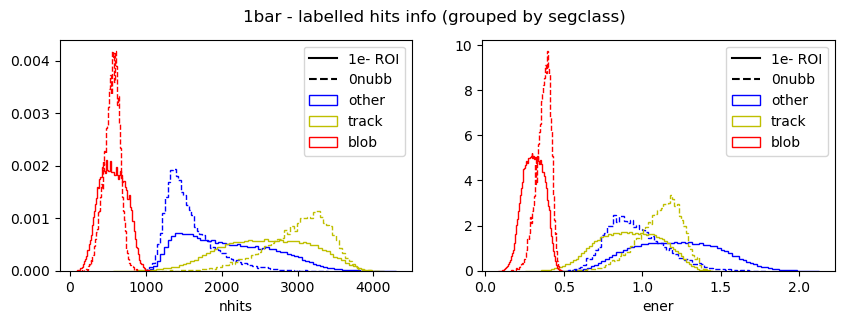

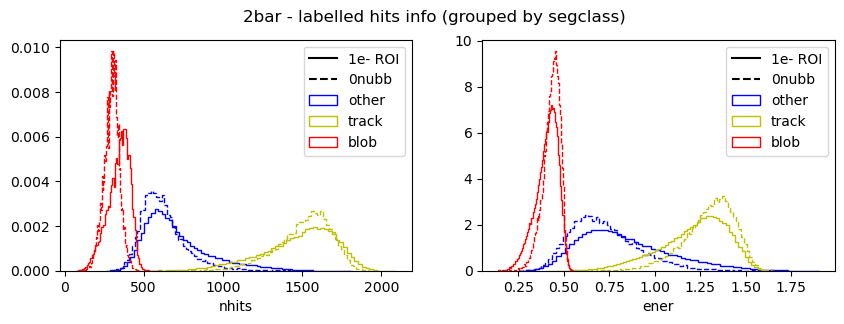

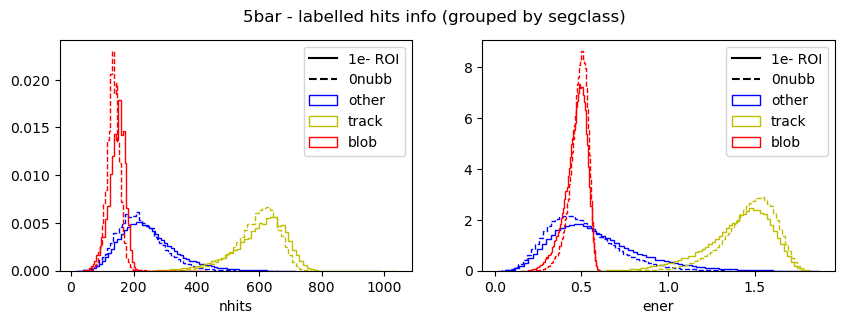

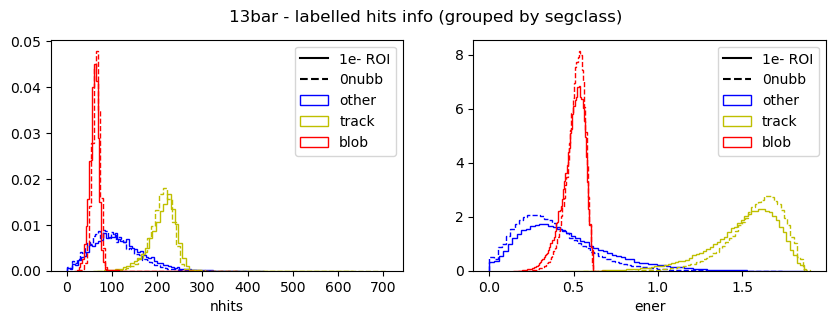

In [15]:
save_path = basedir + 'label_hits_info_df.h5'

results_label_hits_1eroi = pd.read_hdf(save_path, '1eroi')
results_label_hits_0nubb = pd.read_hdf(save_path, '0nubb')

colors = {1:'b', 2:'y', 3:'r'}
label_dict = {1:'other', 2:'track', 3:'blob'}

for p in results_label_hits_1eroi.pressure.unique():
    fig = plt.figure(figsize = (10, 3))
    fig.suptitle(p + ' - labelled hits info (grouped by segclass)')
    ax1, ax2 = fig.add_subplot(121), fig.add_subplot(122)
    for seg in results_label_hits_1eroi.segclass.unique():
        ax1.hist(results_label_hits_1eroi[(results_label_hits_1eroi.pressure == p) & (results_label_hits_1eroi.segclass == seg)].nhits, 70, density = True, color = colors[seg], ls = '-', histtype = 'step', label = label_dict[seg])
        ax1.hist(results_label_hits_0nubb[(results_label_hits_0nubb.pressure == p) & (results_label_hits_0nubb.segclass == seg)].nhits, 70, density = True, color = colors[seg], ls = '--', histtype = 'step')
        ax1.set_xlabel('nhits')
        ax2.hist(results_label_hits_1eroi[(results_label_hits_1eroi.pressure == p) & (results_label_hits_1eroi.segclass == seg)].tot_ene, 70, density = True, color = colors[seg], ls = '-', histtype = 'step', label = label_dict[seg])
        ax2.hist(results_label_hits_0nubb[(results_label_hits_0nubb.pressure == p) & (results_label_hits_0nubb.segclass == seg)].tot_ene, 70, density = True, color = colors[seg], ls = '--', histtype = 'step')
        ax2.set_xlabel('ener')

    ax1.plot([], [], 'k-',  label="1e- ROI")
    ax1.plot([], [], 'k--', label="0nubb")
    ax1.legend()

    ax2.plot([], [], 'k-',  label="1e- ROI")
    ax2.plot([], [], 'k--', label="0nubb")
    ax2.legend()

Vemos que el número de hits de other y track parece que se separa a medida que se disminuye la presión, aunque para 1 bar vemos que está bastante "fusionado": parece que a esta presión los delta electrons tienen bastante protagonismo en número de hits.

En energía según clase de segmentación parece que other y track se asemejan más cuanto más disminuye la presión... es decir que genera más partículas secundarias de energía comparable al e- principal.

Vemos luego que en comparación entre tipos de datos, a medida que sube la presión más similares son

##### Joining blob and track

In [16]:
def join_blob_and_track(results_label):
    results_label['segclass'] = results_label['segclass'].replace(3, 2)
    results_label = results_label.groupby(['pressure', 'dataset_id', 'filenum', 'segclass']).sum().reset_index()
    return results_label

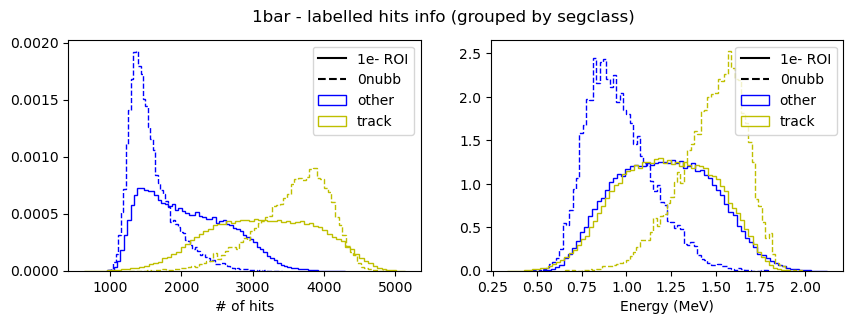

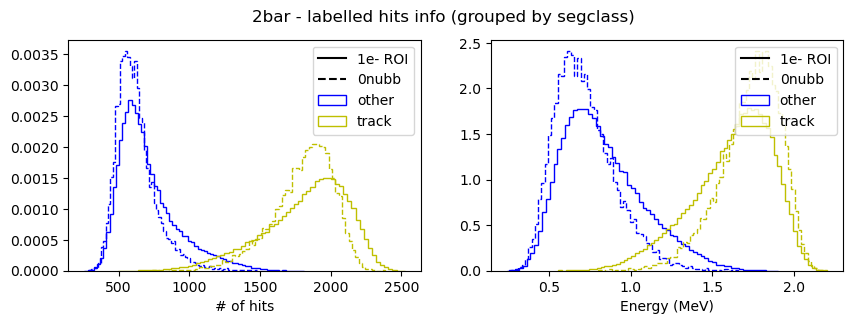

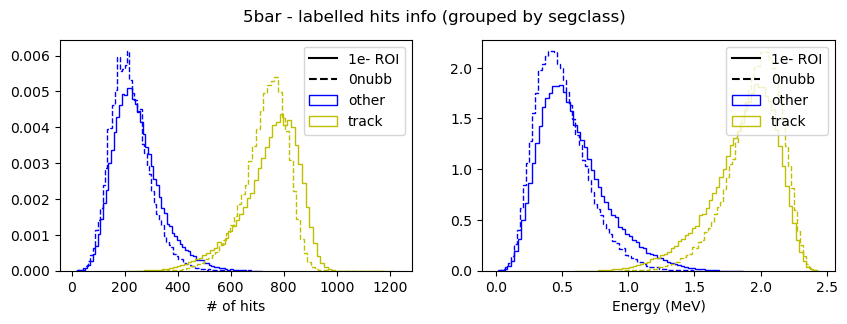

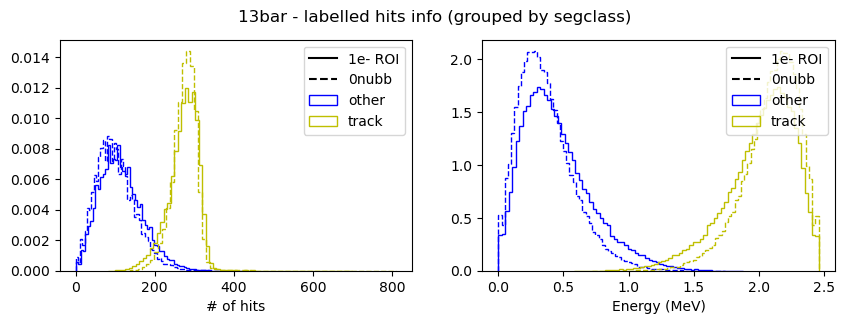

In [67]:
save_path = basedir + 'label_hits_info_df.h5'

results_label_hits_1eroi = pd.read_hdf(save_path, '1eroi')
results_label_hits_0nubb = pd.read_hdf(save_path, '0nubb')

dist_1eroi = results_label_hits_1eroi[results_label_hits_1eroi.segclass == 1]
dist_0nubb = results_label_hits_0nubb[results_label_hits_0nubb.segclass == 1]

results_label_hits_1eroi = join_blob_and_track(results_label_hits_1eroi)
results_label_hits_0nubb = join_blob_and_track(results_label_hits_0nubb)

colors = {1:'b', 2:'y', 3:'r'}
label_dict = {1:'other', 2:'track'}

for p in pressures:
    fig = plt.figure(figsize = (10, 3))
    fig.suptitle(p + ' - labelled hits info (grouped by segclass)')
    ax1, ax2 = fig.add_subplot(121), fig.add_subplot(122)
    for seg in results_label_hits_1eroi.segclass.unique():
        ax1.hist(results_label_hits_1eroi[(results_label_hits_1eroi.pressure == p) & (results_label_hits_1eroi.segclass == seg)].nhits, 70, density = True, color = colors[seg], ls = '-', histtype = 'step', label = label_dict[seg])
        ax1.hist(results_label_hits_0nubb[(results_label_hits_0nubb.pressure == p) & (results_label_hits_0nubb.segclass == seg)].nhits, 70, density = True, color = colors[seg], ls = '--', histtype = 'step')
        ax1.set_xlabel('# of hits')
        ax2.hist(results_label_hits_1eroi[(results_label_hits_1eroi.pressure == p) & (results_label_hits_1eroi.segclass == seg)].tot_ene, 70, density = True, color = colors[seg], ls = '-', histtype = 'step', label = label_dict[seg])
        ax2.hist(results_label_hits_0nubb[(results_label_hits_0nubb.pressure == p) & (results_label_hits_0nubb.segclass == seg)].tot_ene, 70, density = True, color = colors[seg], ls = '--', histtype = 'step')
        ax2.set_xlabel('Energy (MeV)')

    ax1.plot([], [], 'k-',  label="1e- ROI")
    ax1.plot([], [], 'k--', label="0nubb")
    ax1.legend()

    ax2.plot([], [], 'k-',  label="1e- ROI")
    ax2.plot([], [], 'k--', label="0nubb")
    ax2.legend()


#### Plot for each hit individually

##### For all 3 segclass

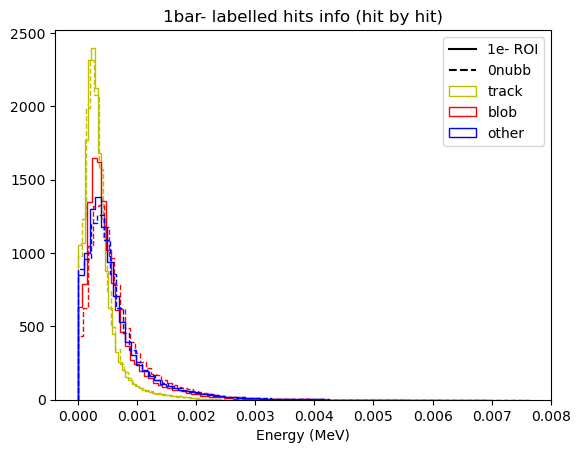

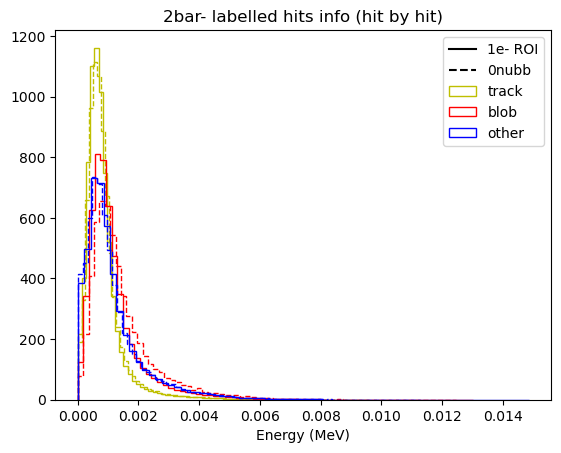

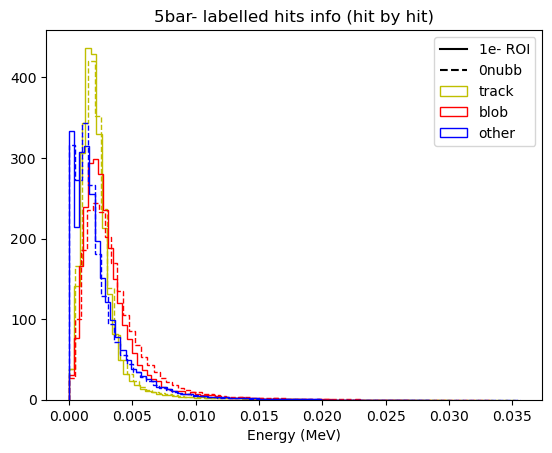

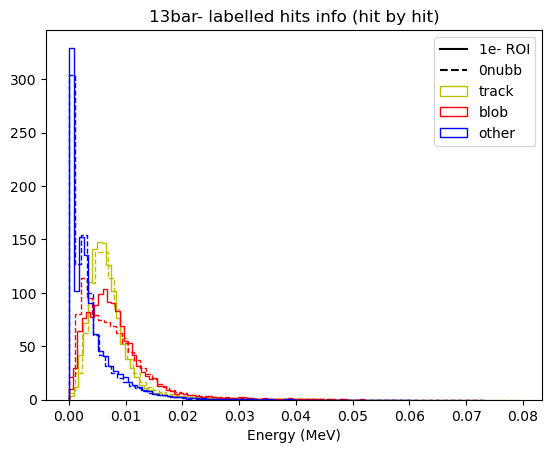

In [18]:
nfiles = 3

_, labelfiles_1eroi, _ = get_file_dict(basedir, '1eroi')
_, labelfiles_0nubb, _ = get_file_dict(basedir, '0nubb')

colors = {1:'b', 2:'y', 3:'r'}
label_dict = {1:'other', 2:'track', 3:'blob'}

for p in pressures:
    hits_1eroi, hits_0nubb = pd.DataFrame([]), pd.DataFrame([])
    for n in range(nfiles):
        hits_1eroi = hits_1eroi.append(pd.read_hdf(labelfiles_1eroi[p][n], 'DATASET/MCHits'))
        hits_0nubb = hits_0nubb.append(pd.read_hdf(labelfiles_0nubb[p][n], 'DATASET/MCHits'))
    
    plt.figure()
    for seg in hits_1eroi.segclass.unique():
        plt.hist(hits_1eroi[(hits_1eroi.segclass == seg)].energy, 70, density = True, color = colors[seg], ls = '-', histtype = 'step', label = label_dict[seg])
        plt.hist(hits_0nubb[(hits_0nubb.segclass == seg)].energy, 70, density = True, color = colors[seg], ls = '--', histtype = 'step')
        plt.xlabel('Energy (MeV)')
    plt.title(p + '- labelled hits info (hit by hit)')
    plt.plot([], [], 'k-',  label="1e- ROI")
    plt.plot([], [], 'k--', label="0nubb")
    plt.legend()

##### Joining blob and track

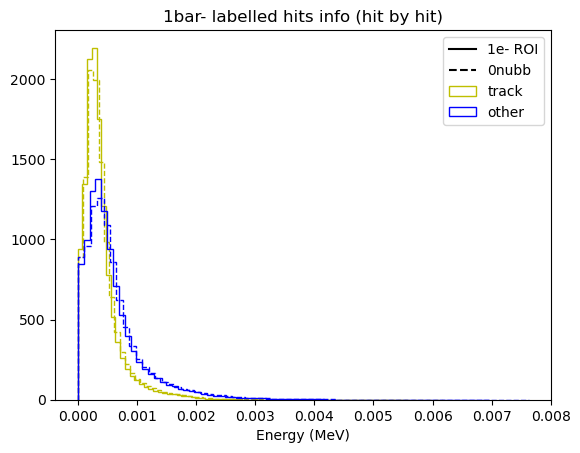

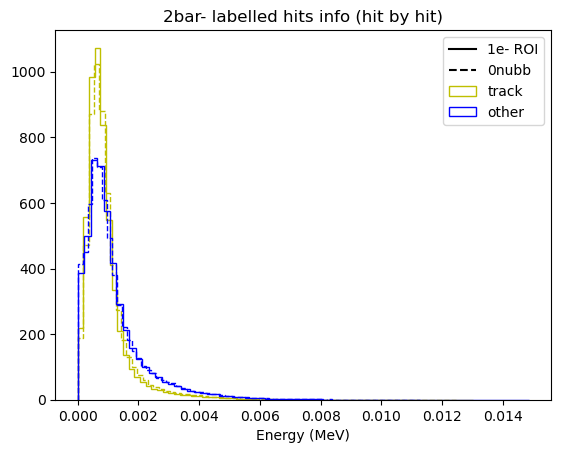

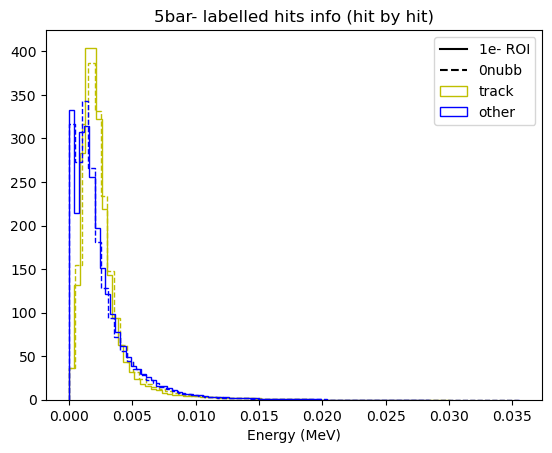

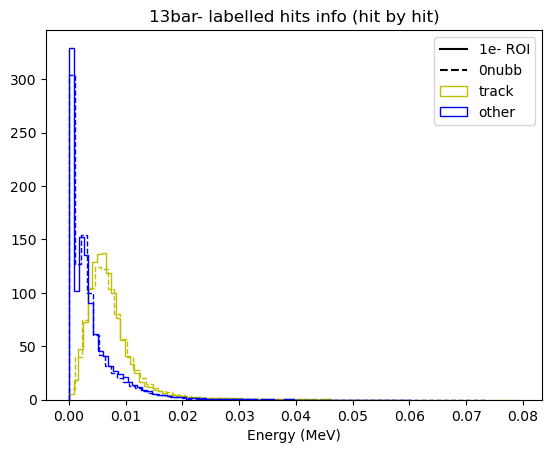

In [19]:
nfiles = 3

_, labelfiles_1eroi, _ = get_file_dict(basedir, '1eroi')
_, labelfiles_0nubb, _ = get_file_dict(basedir, '0nubb')

colors = {1:'b', 2:'y', 3:'r'}
label_dict = {1:'other', 2:'track', 3:'blob'}

for p in pressures:
    hits_1eroi, hits_0nubb = pd.DataFrame([]), pd.DataFrame([])
    for n in range(nfiles):
        hits_1eroi = hits_1eroi.append(pd.read_hdf(labelfiles_1eroi[p][n], 'DATASET/MCHits'))
        hits_0nubb = hits_0nubb.append(pd.read_hdf(labelfiles_0nubb[p][n], 'DATASET/MCHits'))
    
    hits_1eroi['segclass'] = hits_1eroi['segclass'].replace(3, 2)
    hits_0nubb['segclass'] = hits_0nubb['segclass'].replace(3, 2)
    plt.figure()
    for seg in hits_1eroi.segclass.unique():
        plt.hist(hits_1eroi[(hits_1eroi.segclass == seg)].energy, 70, density = True, color = colors[seg], ls = '-', histtype = 'step', label = label_dict[seg])
        plt.hist(hits_0nubb[(hits_0nubb.segclass == seg)].energy, 70, density = True, color = colors[seg], ls = '--', histtype = 'step')
        plt.xlabel('Energy (MeV)')
    plt.title(p + '- labelled hits info (hit by hit)')
    plt.plot([], [], 'k-',  label="1e- ROI")
    plt.plot([], [], 'k--', label="0nubb")
    plt.legend()

#### Distance between extremes

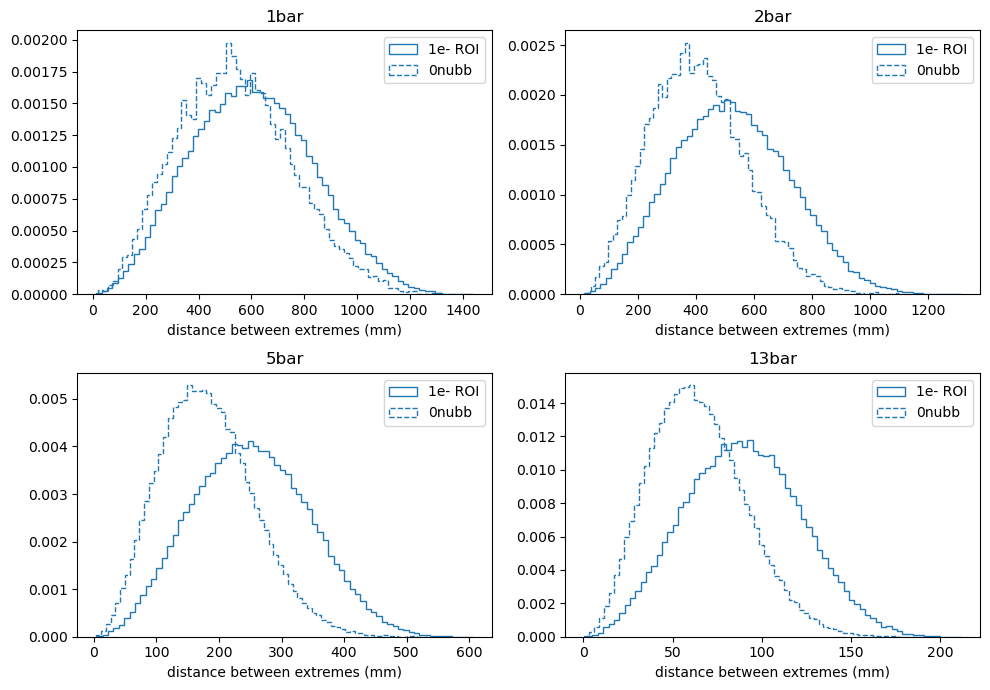

In [70]:
save_path = basedir + 'label_hits_info_df.h5'

results_label_hits_1eroi = pd.read_hdf(save_path, '1eroi')
results_label_hits_0nubb = pd.read_hdf(save_path, '0nubb')

dist_1eroi = results_label_hits_1eroi[results_label_hits_1eroi.segclass == 1]
dist_0nubb = results_label_hits_0nubb[results_label_hits_0nubb.segclass == 1]

plt.figure(figsize=(10, 7))
axes = plt.subplot(221), plt.subplot(222), plt.subplot(223), plt.subplot(224)
for i, p in enumerate(pressures):
    axes[i].hist(dist_1eroi[dist_1eroi.pressure == p].apply(lambda x: np.linalg.norm(x.ext1 - x.ext2), axis = 1), 70, density = True, color = 'tab:blue', ls = '-',  histtype = 'step', label = '1e- ROI')
    axes[i].hist(dist_0nubb[dist_0nubb.pressure == p].apply(lambda x: np.linalg.norm(x.ext1 - x.ext2), axis = 1), 70, density = True, color = 'tab:blue', ls = '--', histtype = 'step', label = '0nubb')
    axes[i].set_title(p)
    axes[i].set_xlabel('distance between extremes (mm)')
    plt.tight_layout()
    axes[i].legend()

### VOXELS

#### Grouping by segclass per event

##### For all 3 segclass

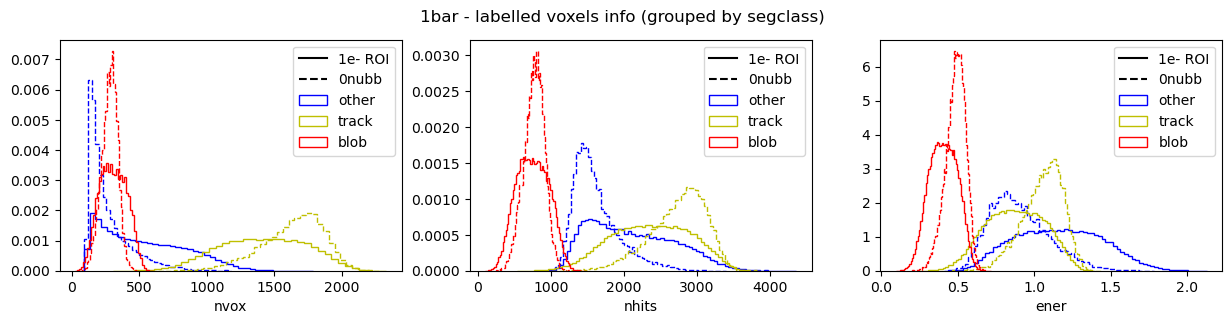

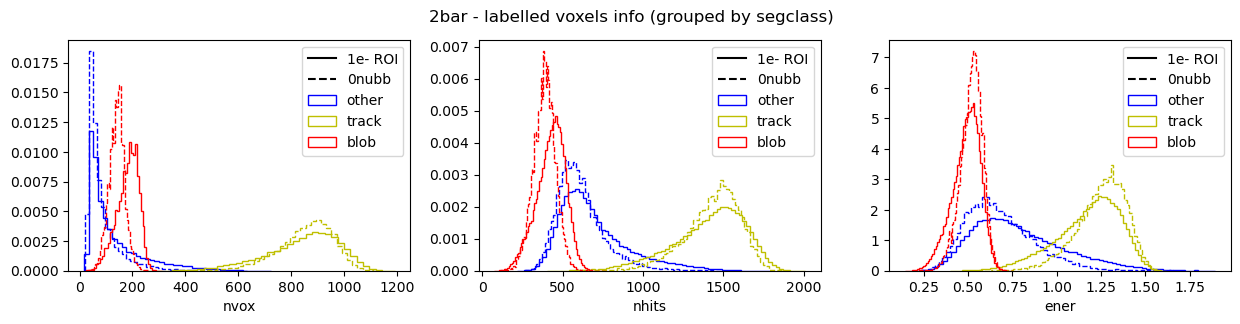

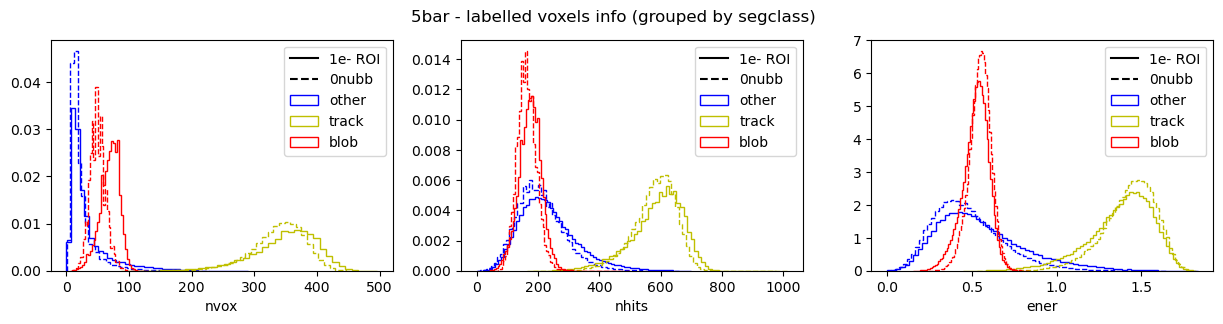

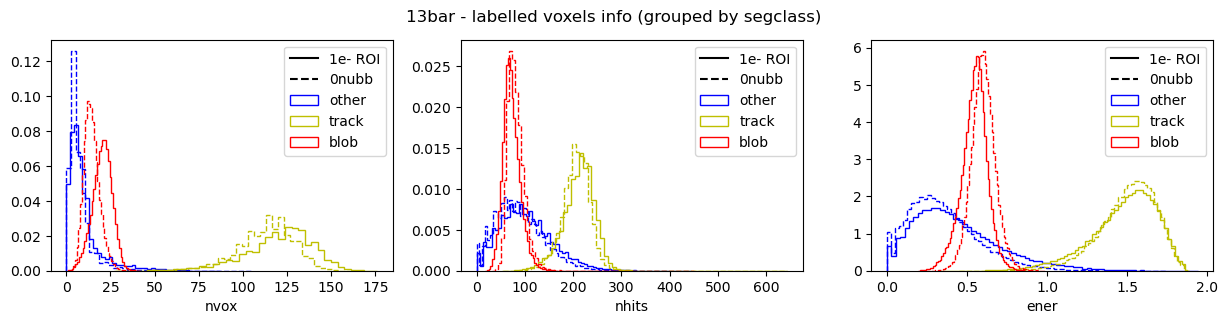

In [20]:
save_path = basedir + 'label_vox_info_df.h5'

results_label_vox_1eroi = pd.read_hdf(save_path, '1eroi')
results_label_vox_0nubb = pd.read_hdf(save_path, '0nubb')

colors = {1:'b', 2:'y', 3:'r'}
label_dict = {1:'other', 2:'track', 3:'blob'}

for p in results_label_vox_1eroi.pressure.unique():
    fig = plt.figure(figsize = (15, 3))
    fig.suptitle(p + ' - labelled voxels info (grouped by segclass)')
    ax1, ax2, ax3 = fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133)
    for seg in results_label_vox_1eroi.segclass.unique():
        ax1.hist(results_label_vox_1eroi[(results_label_vox_1eroi.pressure == p) & (results_label_vox_1eroi.segclass == seg)].nvox, 40, density = True, color = colors[seg], ls = '-', histtype = 'step', label = label_dict[seg])
        ax1.hist(results_label_vox_0nubb[(results_label_vox_0nubb.pressure == p) & (results_label_vox_0nubb.segclass == seg)].nvox, 40, density = True, color = colors[seg], ls = '--', histtype = 'step')
        ax1.set_xlabel('nvox')
        ax2.hist(results_label_vox_1eroi[(results_label_vox_1eroi.pressure == p) & (results_label_vox_1eroi.segclass == seg)].nhits, 70, density = True, color = colors[seg], ls = '-', histtype = 'step', label = label_dict[seg])
        ax2.hist(results_label_vox_0nubb[(results_label_vox_0nubb.pressure == p) & (results_label_vox_0nubb.segclass == seg)].nhits, 70, density = True, color = colors[seg], ls = '--', histtype = 'step')
        ax2.set_xlabel('nhits')
        ax3.hist(results_label_vox_1eroi[(results_label_vox_1eroi.pressure == p) & (results_label_vox_1eroi.segclass == seg)].tot_ene, 70, density = True, color = colors[seg], ls = '-', histtype = 'step', label = label_dict[seg])
        ax3.hist(results_label_vox_0nubb[(results_label_vox_0nubb.pressure == p) & (results_label_vox_0nubb.segclass == seg)].tot_ene, 70, density = True, color = colors[seg], ls = '--', histtype = 'step')
        ax3.set_xlabel('ener')

    ax1.plot([], [], 'k-',  label="1e- ROI")
    ax1.plot([], [], 'k--', label="0nubb")
    ax1.legend()

    ax2.plot([], [], 'k-',  label="1e- ROI")
    ax2.plot([], [], 'k--', label="0nubb")
    ax2.legend()

    ax3.plot([], [], 'k-',  label="1e- ROI")
    ax3.plot([], [], 'k--', label="0nubb")
    ax3.legend()

En voxeles, la energía se comporta bastante parecido (ok), luego 

##### Joining blob and track

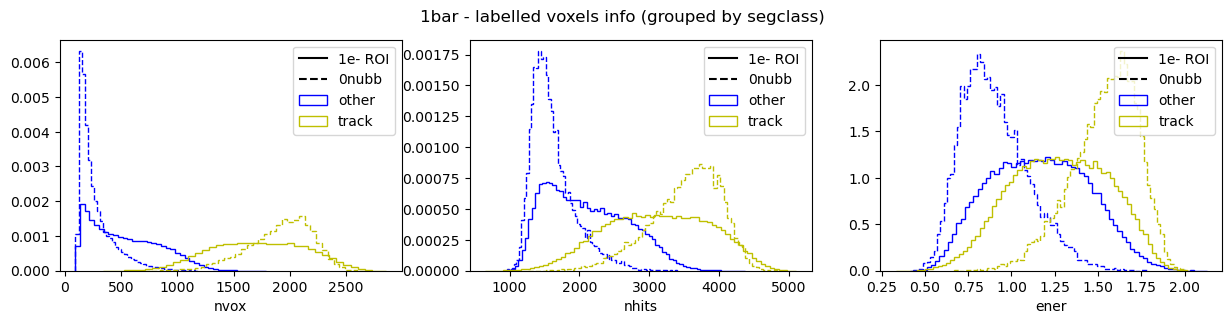

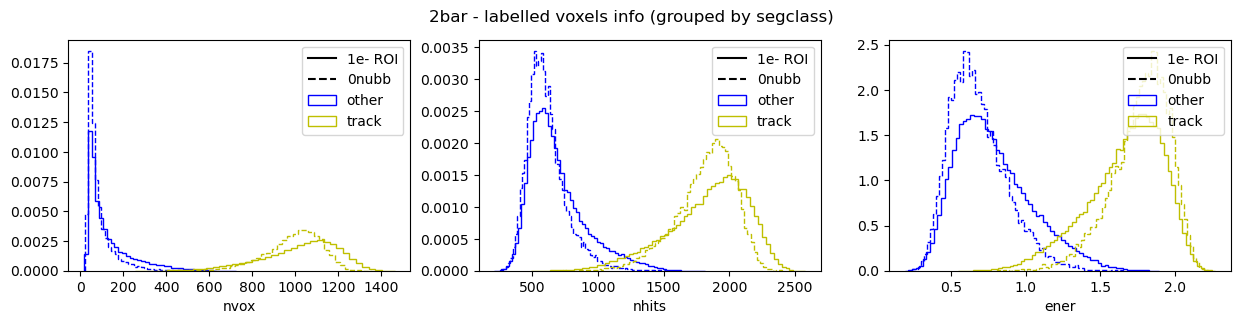

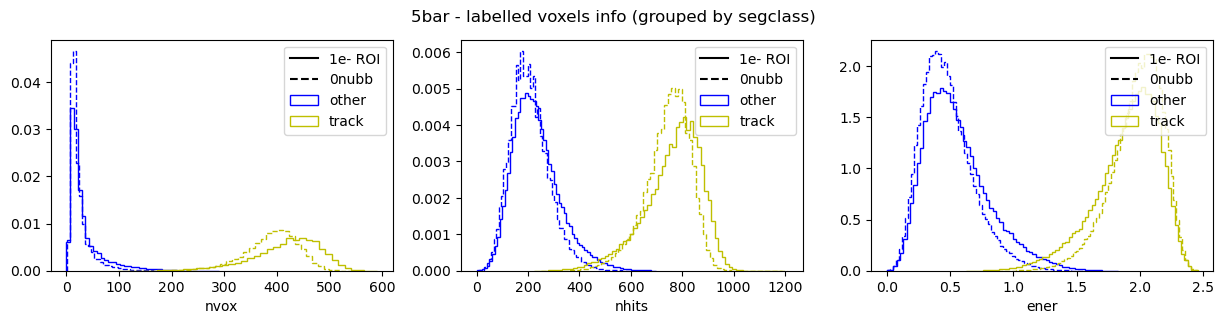

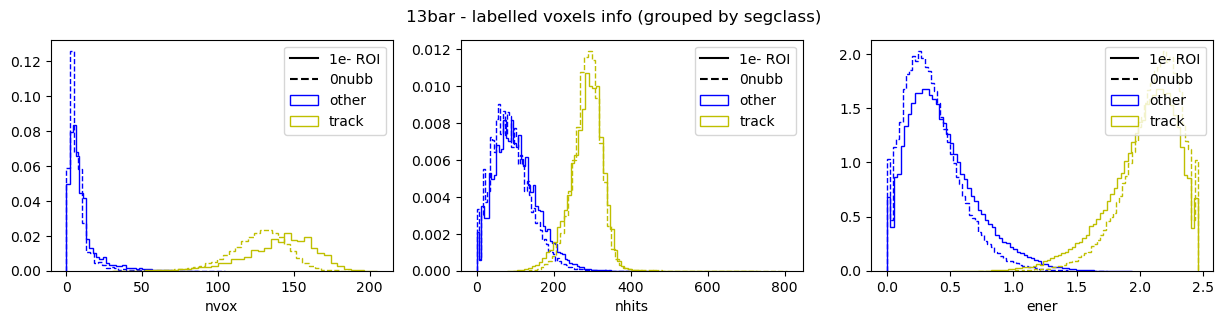

In [21]:
save_path = basedir + 'label_vox_info_df.h5'

results_label_vox_1eroi = pd.read_hdf(save_path, '1eroi')
results_label_vox_0nubb = pd.read_hdf(save_path, '0nubb')

results_label_vox_1eroi = join_blob_and_track(results_label_vox_1eroi)
results_label_vox_0nubb = join_blob_and_track(results_label_vox_0nubb)

colors = {1:'b', 2:'y', 3:'r'}
label_dict = {1:'other', 2:'track'}

for p in pressures:
    fig = plt.figure(figsize = (15, 3))
    fig.suptitle(p + ' - labelled voxels info (grouped by segclass)')
    ax1, ax2, ax3 = fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133)
    for seg in results_label_vox_1eroi.segclass.unique():
        ax1.hist(results_label_vox_1eroi[(results_label_vox_1eroi.pressure == p) & (results_label_vox_1eroi.segclass == seg)].nvox, 40, density = True, color = colors[seg], ls = '-', histtype = 'step', label = label_dict[seg])
        ax1.hist(results_label_vox_0nubb[(results_label_vox_0nubb.pressure == p) & (results_label_vox_0nubb.segclass == seg)].nvox, 40, density = True, color = colors[seg], ls = '--', histtype = 'step')
        ax1.set_xlabel('nvox')
        ax2.hist(results_label_vox_1eroi[(results_label_vox_1eroi.pressure == p) & (results_label_vox_1eroi.segclass == seg)].nhits, 70, density = True, color = colors[seg], ls = '-', histtype = 'step', label = label_dict[seg])
        ax2.hist(results_label_vox_0nubb[(results_label_vox_0nubb.pressure == p) & (results_label_vox_0nubb.segclass == seg)].nhits, 70, density = True, color = colors[seg], ls = '--', histtype = 'step')
        ax2.set_xlabel('nhits')
        ax3.hist(results_label_vox_1eroi[(results_label_vox_1eroi.pressure == p) & (results_label_vox_1eroi.segclass == seg)].tot_ene, 70, density = True, color = colors[seg], ls = '-', histtype = 'step', label = label_dict[seg])
        ax3.hist(results_label_vox_0nubb[(results_label_vox_0nubb.pressure == p) & (results_label_vox_0nubb.segclass == seg)].tot_ene, 70, density = True, color = colors[seg], ls = '--', histtype = 'step')
        ax3.set_xlabel('ener')

    ax1.plot([], [], 'k-',  label="1e- ROI")
    ax1.plot([], [], 'k--', label="0nubb")
    ax1.legend()

    ax2.plot([], [], 'k-',  label="1e- ROI")
    ax2.plot([], [], 'k--', label="0nubb")
    ax2.legend()

    ax3.plot([], [], 'k-',  label="1e- ROI")
    ax3.plot([], [], 'k--', label="0nubb")
    ax3.legend()

Lo mas destacable es que a 1bar para los 1eroi la energía es muy similar entre traza y other, pero aun así las longitudes son bastante diferenciables... Entiendo tb que es porque cuentan los de 1 voxel que están siempre por el medio etc...

#### Plot for each voxel individually

##### For all 3 segclass

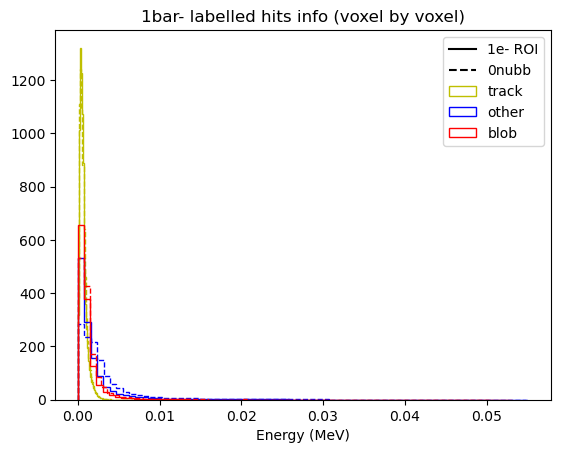

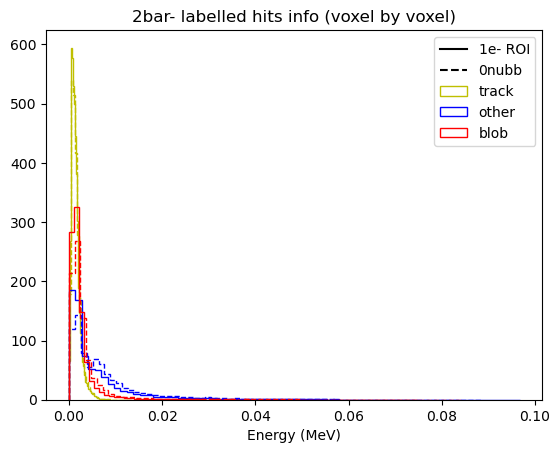

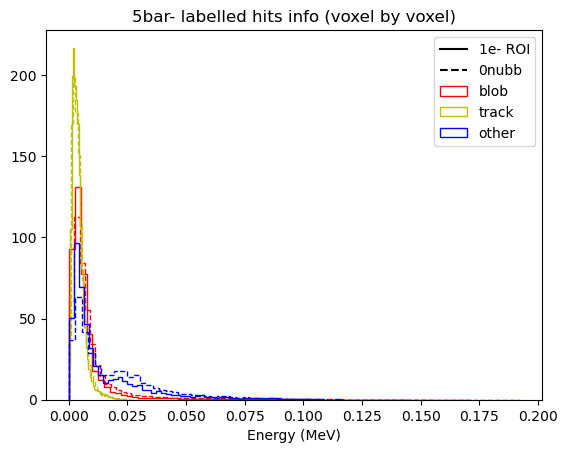

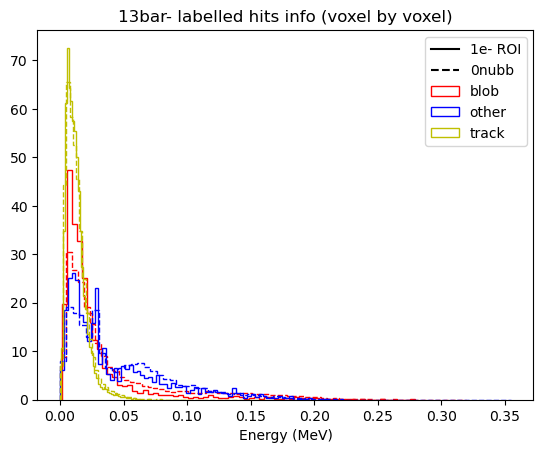

In [22]:
nfiles = 3

_, labelfiles_1eroi, _ = get_file_dict(basedir, '1eroi')
_, labelfiles_0nubb, _ = get_file_dict(basedir, '0nubb')

colors = {1:'b', 2:'y', 3:'r'}
label_dict = {1:'other', 2:'track', 3:'blob'}

for p in pressures:
    hits_1eroi, hits_0nubb = pd.DataFrame([]), pd.DataFrame([])
    for n in range(nfiles):
        hits_1eroi = hits_1eroi.append(pd.read_hdf(labelfiles_1eroi[p][n], 'DATASET/MCVoxels'))
        hits_0nubb = hits_0nubb.append(pd.read_hdf(labelfiles_0nubb[p][n], 'DATASET/MCVoxels'))
    
    plt.figure()
    for seg in hits_1eroi.segclass.unique():
        plt.hist(hits_1eroi[(hits_1eroi.segclass == seg)].ener, 70, density = True, color = colors[seg], ls = '-', histtype = 'step', label = label_dict[seg])
        plt.hist(hits_0nubb[(hits_0nubb.segclass == seg)].ener, 70, density = True, color = colors[seg], ls = '--', histtype = 'step')
        plt.xlabel('Energy (MeV)')
    plt.title(p + '- labelled hits info (voxel by voxel)')
    plt.plot([], [], 'k-',  label="1e- ROI")
    plt.plot([], [], 'k--', label="0nubb")
    plt.legend()

##### Joining blob and track

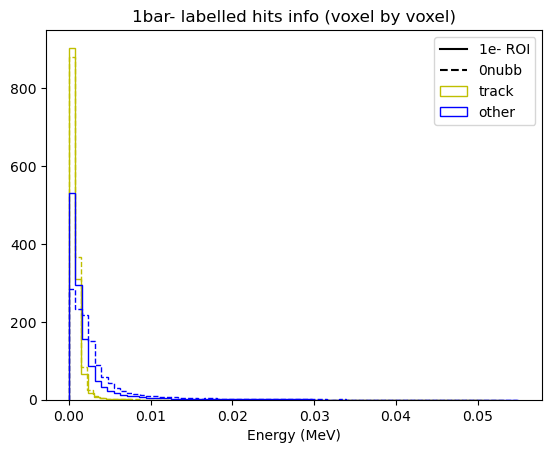

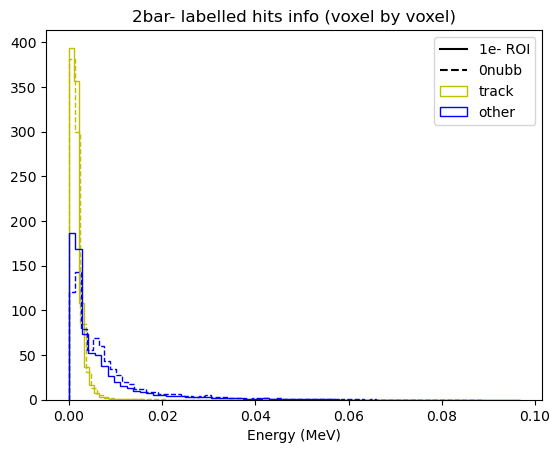

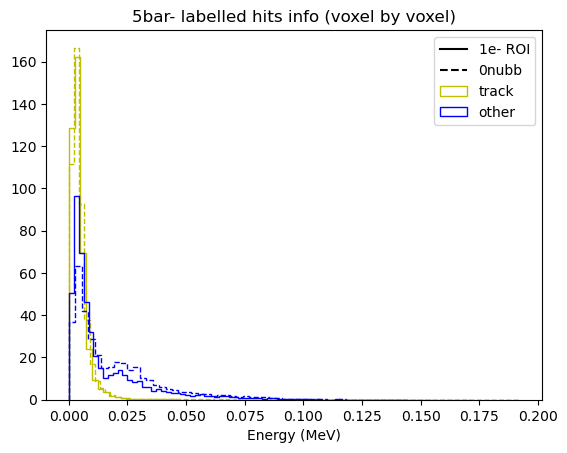

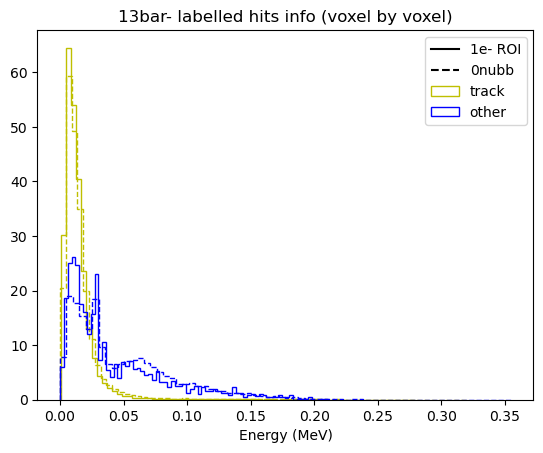

In [23]:
nfiles = 3

_, labelfiles_1eroi, _ = get_file_dict(basedir, '1eroi')
_, labelfiles_0nubb, _ = get_file_dict(basedir, '0nubb')

colors = {1:'b', 2:'y', 3:'r'}
label_dict = {1:'other', 2:'track', 3:'blob'}

for p in pressures:
    hits_1eroi, hits_0nubb = pd.DataFrame([]), pd.DataFrame([])
    for n in range(nfiles):
        hits_1eroi = hits_1eroi.append(pd.read_hdf(labelfiles_1eroi[p][n], 'DATASET/MCVoxels'))
        hits_0nubb = hits_0nubb.append(pd.read_hdf(labelfiles_0nubb[p][n], 'DATASET/MCVoxels'))
    
    hits_1eroi['segclass'] = hits_1eroi['segclass'].replace(3, 2)
    hits_0nubb['segclass'] = hits_0nubb['segclass'].replace(3, 2)
    plt.figure()
    for seg in hits_1eroi.segclass.unique():
        plt.hist(hits_1eroi[(hits_1eroi.segclass == seg)].ener, 70, density = True, color = colors[seg], ls = '-', histtype = 'step', label = label_dict[seg])
        plt.hist(hits_0nubb[(hits_0nubb.segclass == seg)].ener, 70, density = True, color = colors[seg], ls = '--', histtype = 'step')
        plt.xlabel('Energy (MeV)')
    plt.title(p + '- labelled hits info (voxel by voxel)')
    plt.plot([], [], 'k-',  label="1e- ROI")
    plt.plot([], [], 'k--', label="0nubb")
    plt.legend()

## SEPARATION STATS

Number of separated tracks, interrupted tracks...

In [5]:
from utils.statistics_utils.stats_functions import create_df_cloud_stats

In [6]:
def get_separation_info(file_dict, save_path, dt):
    for p in file_dict:
        print(p)
        for f in file_dict[p]:
            fname = f.split('/')[-1]
            voxels = pd.read_hdf(f, 'DATASET/MCVoxels')
            rates, _ = create_df_cloud_stats(int(fname.split('_')[-2]), fname, voxels)
            rates.insert(len(rates.columns), 'pressure', p)
            rates.to_hdf(save_path, dt, append = True, min_itemsize = {'filename':30, 'pressure':5})

In [7]:
save_path = basedir + 'segclass_info_df.h5'

# dt = '1eroi'
# nexusfiles, labelfiles, graphfiles = get_file_dict(basedir, dt)
# get_separation_info(labelfiles, save_path, dt)

# dt = '0nubb'
# nexusfiles, labelfiles, graphfiles = get_file_dict(basedir, dt)
# get_separation_info(labelfiles, save_path, dt)

In [10]:
stats_df

filenumber  nevents  blobtrack_out  sep_track  interr_track  sep_blob  \
0            1       32       0.062500   0.062500      0.937500  0.000000   
0            2       31       0.000000   0.000000      1.000000  0.000000   
0            3       45       0.066667   0.066667      0.933333  0.000000   
0            4       45       0.088889   0.066667      0.933333  0.022222   
0            5       39       0.025641   0.025641      0.974359  0.000000   
..         ...      ...            ...        ...           ...       ...   
0          246      415       0.000000   0.000000      0.506024  0.000000   
0          247      435       0.000000   0.000000      0.540230  0.000000   
0          248      418       0.002392   0.002392      0.533493  0.000000   
0          249      423       0.000000   0.000000      0.527187  0.000000   
0          250      437       0.000000   0.000000      0.537757  0.000000   

    interr_blob  bad_blob_count                  filename pressure  
0           0.0        0.000000    nexus_label_1_1eroi.h5     1bar  
0           0.0        0.000000    nexus_label_2_1eroi.h5     1bar  
0           0.0        0.000000    nexus_label_3_1eroi.h5     1bar  
0           0.0        0.022222    nexus_label_4_1eroi.h5     1bar  
0           0.0        0.000000    nexus_label_5_1eroi.h5     1bar  
..          ...             ...                       ...      ...  
0           0.0        0.000000  nexus_label_246_1eroi.h5    20bar  
0           0.0        0.000000  nexus_label_247_1eroi.h5    20bar  
0           0.0        0.000000  nexus_label_248_1eroi.h5    20bar  
0           0.0        0.000000  nexus_label_249_1eroi.h5    20bar  
0           0.0        0.000000  nexus_label_250_1eroi.h5    20bar  

[8250 rows x 10 columns]

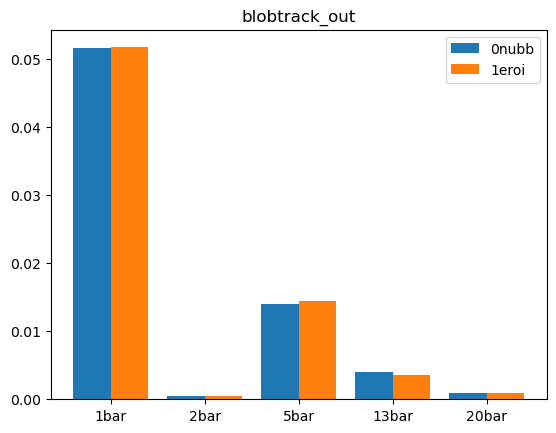

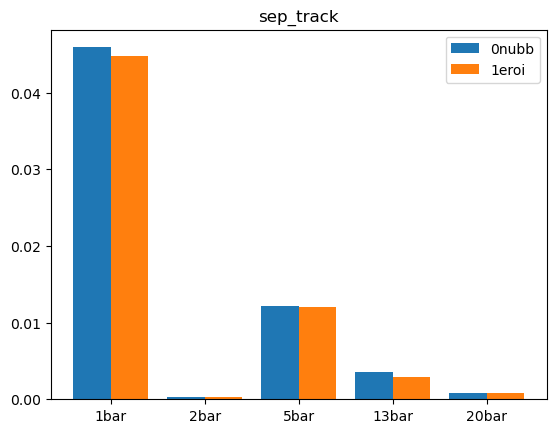

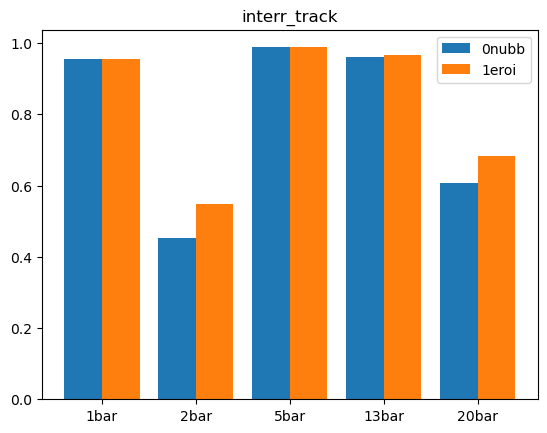

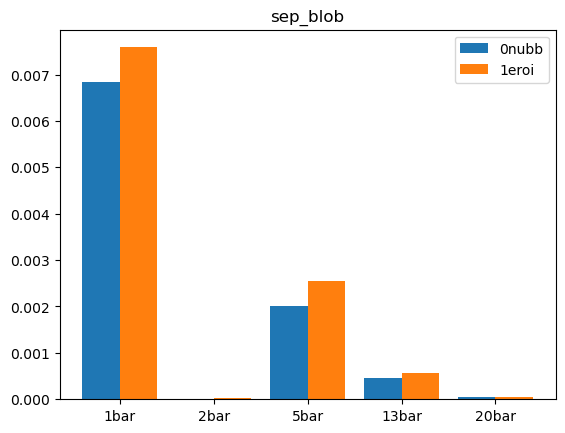

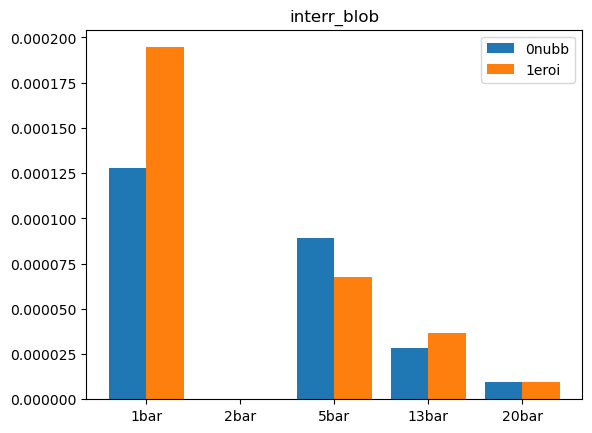

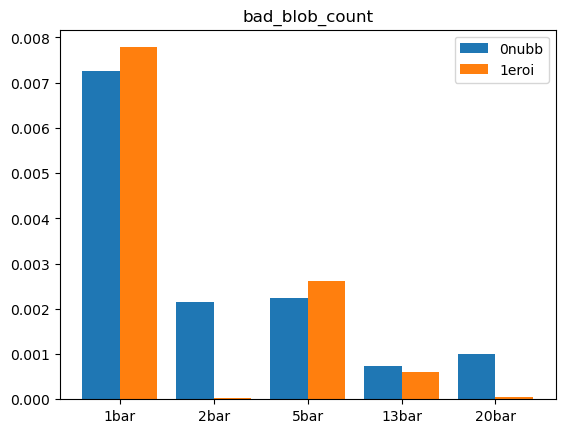

In [9]:
columns = ['blobtrack_out', 'sep_track', 'interr_track', 'sep_blob', 'interr_blob', 'bad_blob_count']
pressures = ['1bar', '2bar', '5bar', '13bar', '20bar']
data_types = ['0nubb', '1eroi']
width = 0.4
x = np.arange(len(pressures))

for i, dt in enumerate(data_types):
    for j, issue in enumerate(columns):
        plt.figure(j)
        stats_df = pd.read_hdf(basedir + 'segclass_info_df.h5', dt)
        values = []
        for p, df in stats_df.groupby('pressure'): values.append(sum(df.nevents * df[issue]) / sum(df.nevents))
        #order values
        values.append(values.pop(0))
        plt.bar(x + i*width - (width * (len(data_types) - 1)) / 2, values, width, label = dt)
        plt.title(issue)
        plt.xticks(x, pressures)
        plt.legend()

Como veo en los plots luego, la mayor parte (si no todos) de blobs interrumpidos son realmente blobs separados, lo que pasa es que se retuerce y el trozo que se separa llega a tocar la traza, entonces en mi análisis es como si hubiera 2 trozos de blob separados por traza y punch.

En bad blob count, para 1eroi suele ser los mismos que sep_blob (lo cual tiene sentido), y para 0nubb suele ser que se juntan las dos puntas de las trazas.

Plot some "problematic" cases

/scratch/6093552/ipykernel_3821193/1142566156.py:160: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels[0])
/scratch/6093552/ipykernel_3821193/1142566156.py:162: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels[1])
/scratch/6093552/ipykernel_3821193/1142566156.py:164: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_zticklabels(labels[2])


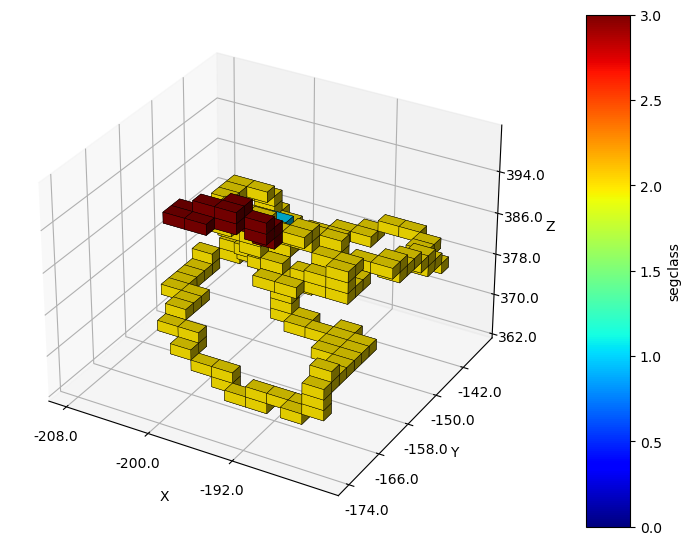

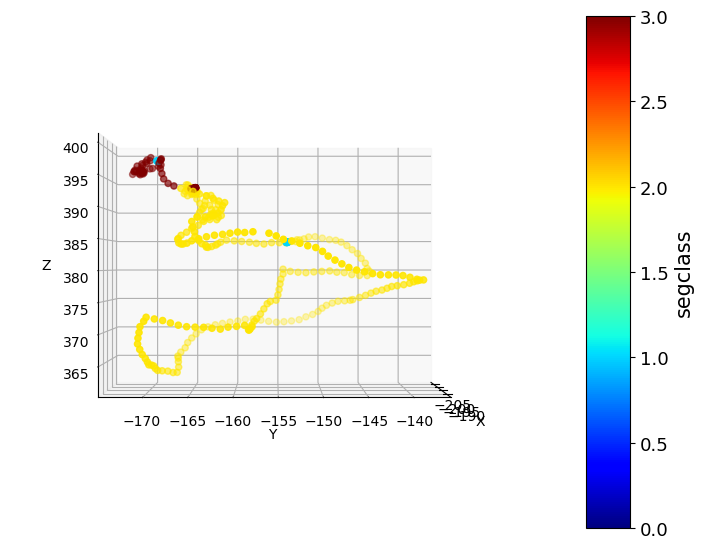

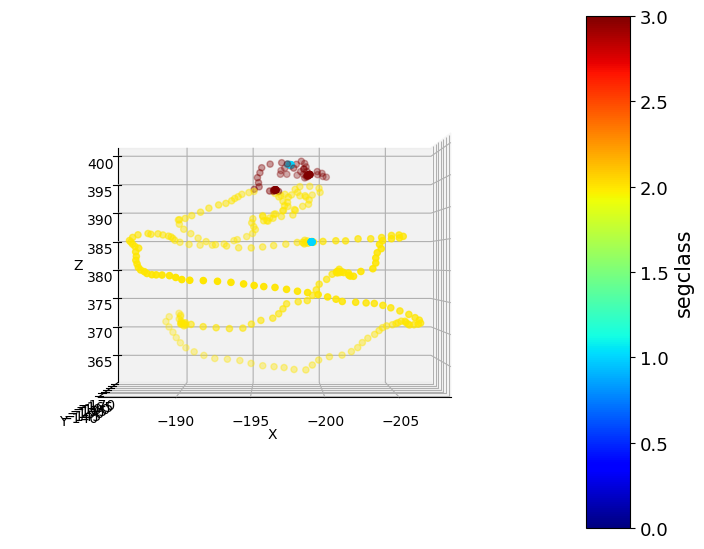

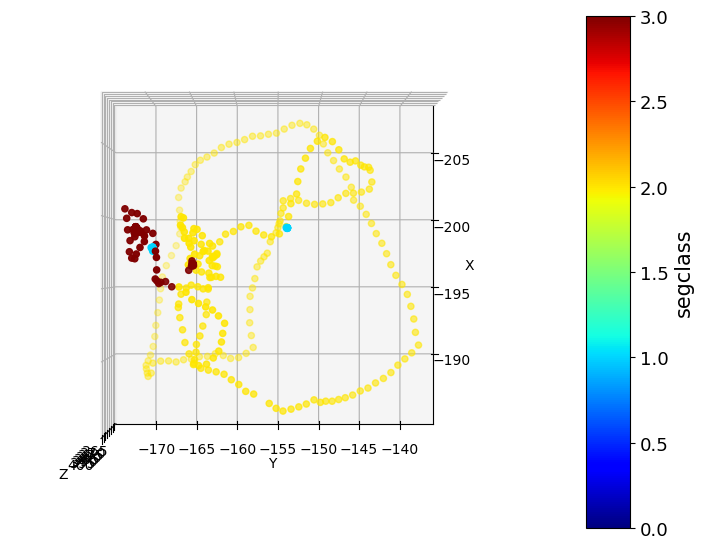

In [55]:
p = '13bar'
data_type = '0nubb'
select_issue = 'bad_blob_count'
select_issue_filenum = 4

stats_df = pd.read_hdf(basedir + 'segclass_info_df.h5', data_type)
issue_df = stats_df[(stats_df[select_issue] != 0) & (stats_df['pressure'] == p)]
issue_filenum = issue_df.filenumber.values 

file = '/{}/{}/label/prod/nexus_label_{}_{}.h5'.format(p, data_type, issue_filenum[select_issue_filenum], data_type)

hits = pd.read_hdf(basedir + file, 'DATASET/MCHits')
voxels = pd.read_hdf(basedir + file, 'DATASET/MCVoxels')
bins_info = pd.read_hdf(basedir + file, 'DATASET/BinsInfo')

sep_num = create_df_cloud_stats(0, '_', voxels)[1][select_issue].values[0][0][0]

voxel_ev = voxels[voxels.dataset_id == sep_num]
hits_ev  = hits[hits.dataset_id == sep_num]

# plot_3d_hits(hits_ev, 'segclass')
plot_3d_vox (voxel_ev, (2, 2, 2), 'segclass', bins_info, affluence = (4, 4, 4))

plot_3d_hits(hits_ev, 'segclass', rotate = [0, 0])
plot_3d_hits(hits_ev, 'segclass', rotate = [0, 90])
plot_3d_hits(hits_ev, 'segclass', rotate = [90, 0])
# plot_3d_vox (voxel_ev, (2, 2, 2), 'segclass', bins_info, affluence = (4, 4, 4), rotate = [0, 0])
# plot_3d_vox (voxel_ev, (2, 2, 2), 'segclass', bins_info, affluence = (4, 4, 4), rotate = [0, 90])
# plot_3d_vox (voxel_ev, (2, 2, 2), 'segclass', bins_info, affluence = (4, 4, 4), rotate = [90, 0])

## PAOLINA

In [5]:
def get_tracks_info(file_dict):
    results = pd.DataFrame([])
    for p in file_dict:
        print(p)
        for f in file_dict[p]:
            fnum = int(f.split('_')[-2])
            tracks = pd.read_hdf(f, 'DATASET/IsauraMCInfo')
            tracks = tracks[tracks.trackID == 0][['event', 'energy', 'length', 
                                                  'numb_of_voxels', 'numb_of_hits', 'numb_of_tracks', 
                                                  'eblob1', 'eblob2', 'ovlp_blob_energy']]
            tracks.insert(len(tracks.columns), 'pressure', p)
            tracks.insert(len(tracks.columns), 'filenum',  fnum)
            results = results.append(tracks)
    return results

In [6]:
save_path = basedir + 'track_info_df.h5'

# dt = '1eroi'
# nexusfiles, labelfiles, graphfiles = get_file_dict(basedir, dt)
# results = get_tracks_info(labelfiles)
# results.to_hdf(save_path, dt)

# dt = '0nubb'
# nexusfiles, labelfiles, graphfiles = get_file_dict(basedir, dt)
# results = get_tracks_info(labelfiles)
# results.to_hdf(save_path, dt)

#### Plot each variables for all P

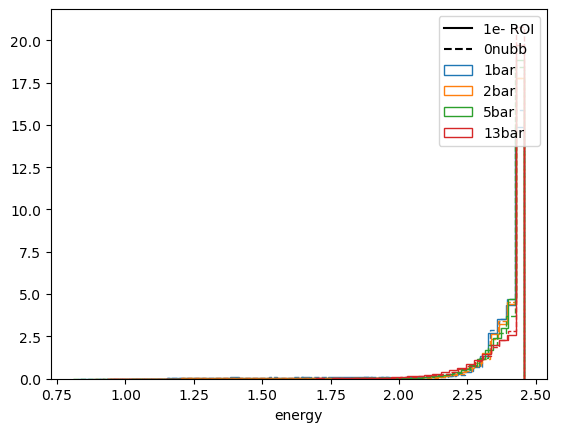

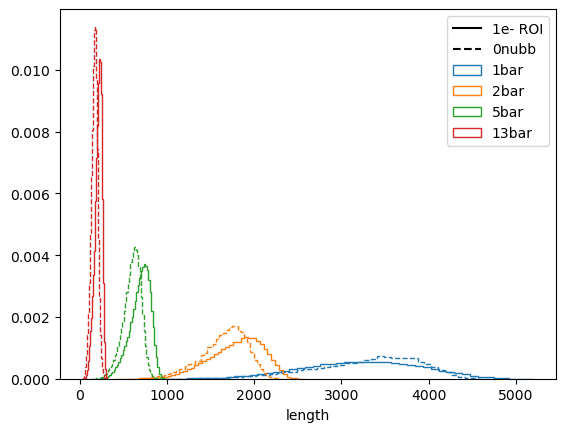

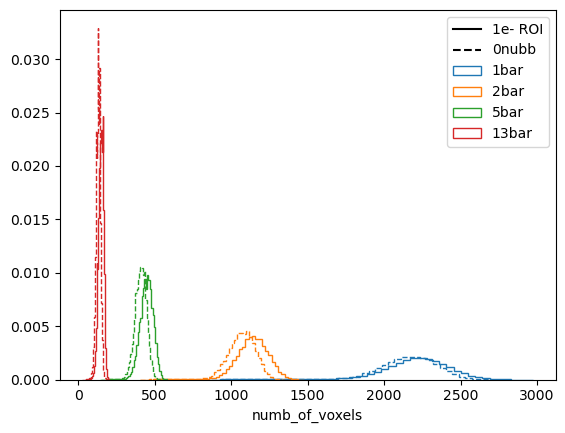

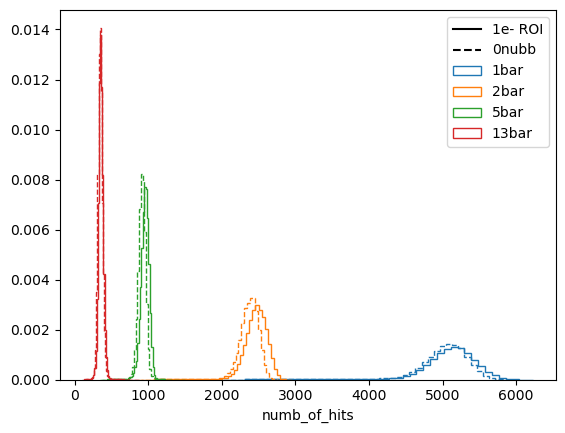

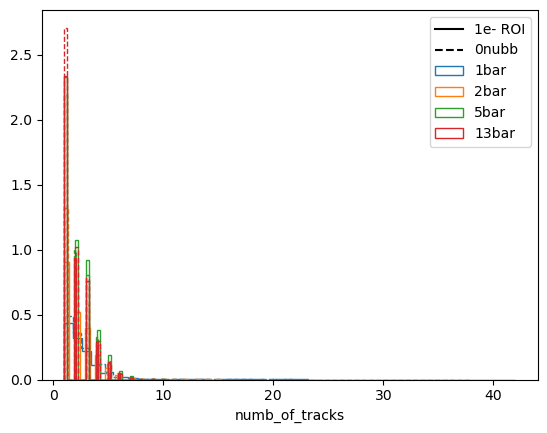

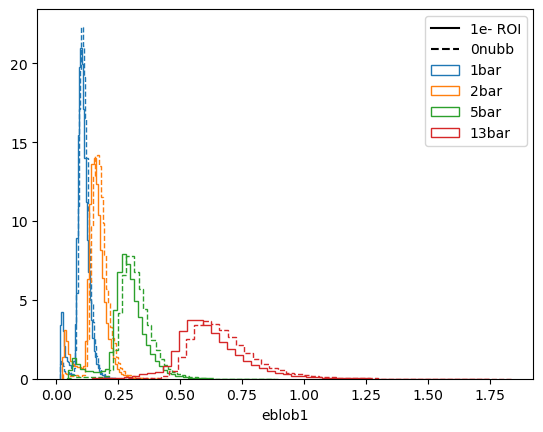

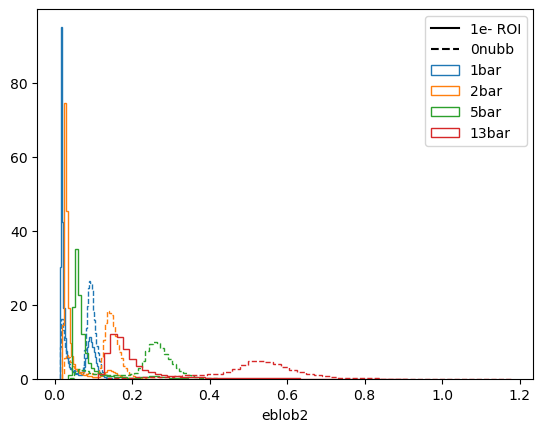

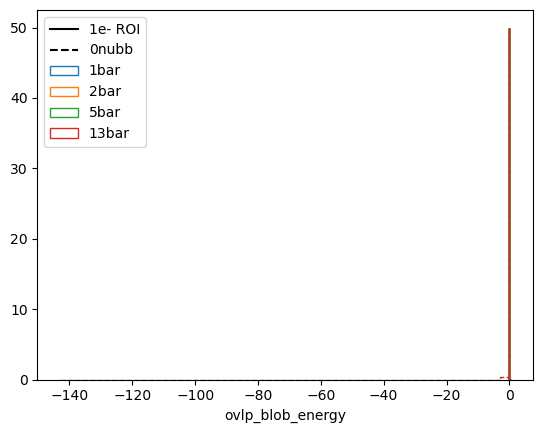

In [31]:
save_path = basedir + 'track_info_df.h5'

results_tracks_1eroi = pd.read_hdf(save_path, '1eroi')
results_tracks_0nubb = pd.read_hdf(save_path, '0nubb')

plot_dict = {'1bar':'tab:blue', '2bar':'tab:orange', '5bar':'tab:green', '13bar':'tab:red'}

for feature in ['energy', 'length', 'numb_of_voxels', 'numb_of_hits', 'numb_of_tracks', 'eblob1', 'eblob2', 'ovlp_blob_energy']:
    for p in results_tracks_1eroi.pressure.unique():
        plt.hist(results_tracks_1eroi[results_tracks_1eroi.pressure == p][feature], 50, color = plot_dict[p], ls = '-',  histtype='step', density = True, label = p)
        plt.hist(results_tracks_0nubb[results_tracks_0nubb.pressure == p][feature], 50, color = plot_dict[p], ls = '--', histtype='step', density = True)
        plt.xlabel(feature)
        #plt.yscale('log')
    plt.plot([], [], 'k-',  label="1e- ROI")
    plt.plot([], [], 'k--', label="0nubb")
    plt.legend()
    plt.show()

#### Plot each variables for each P

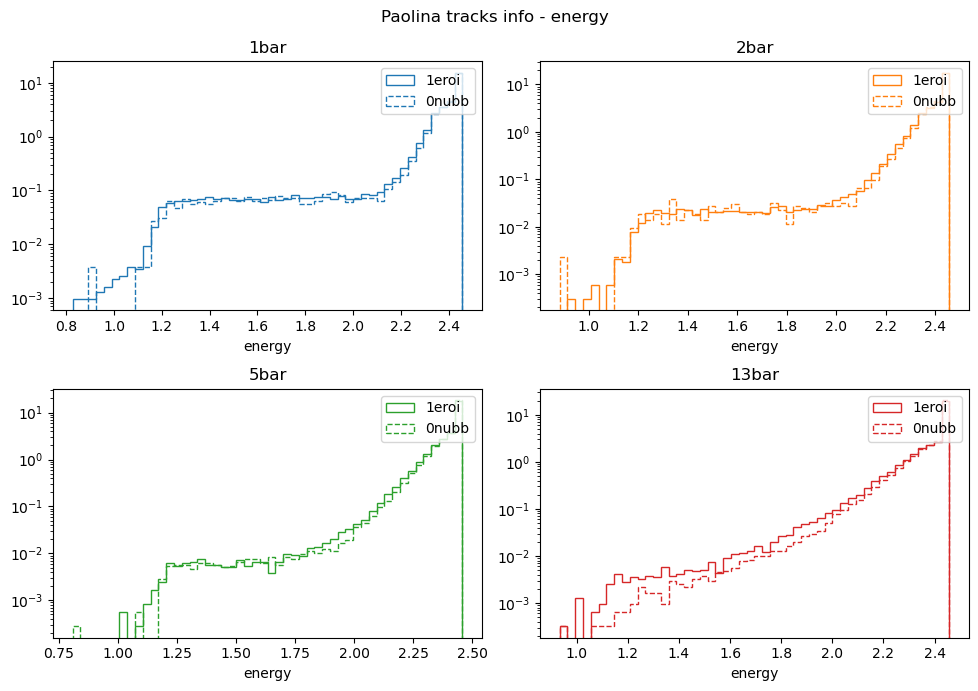

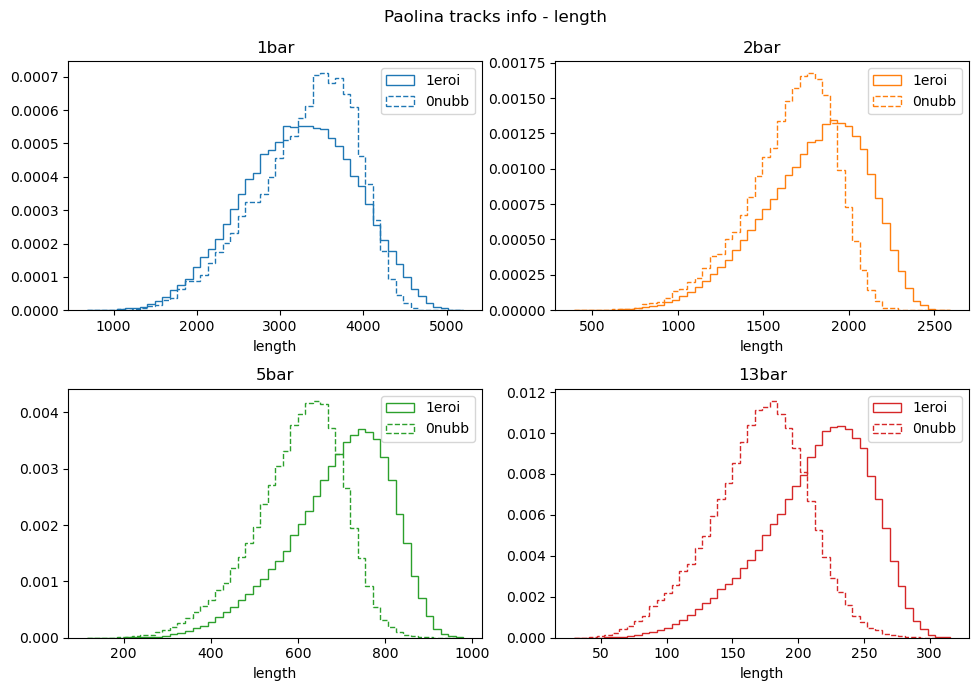

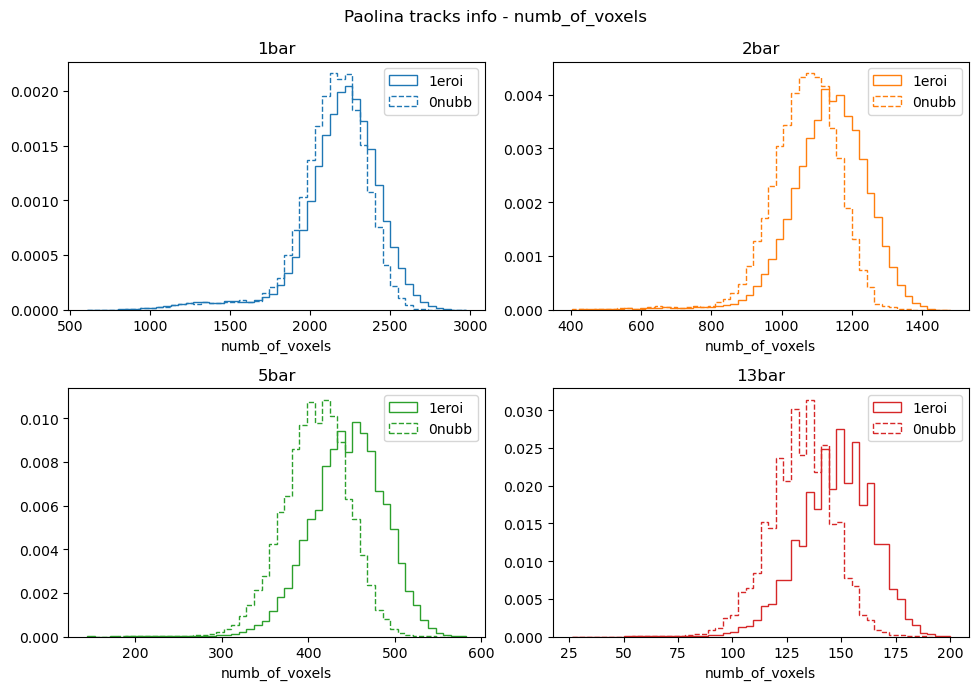

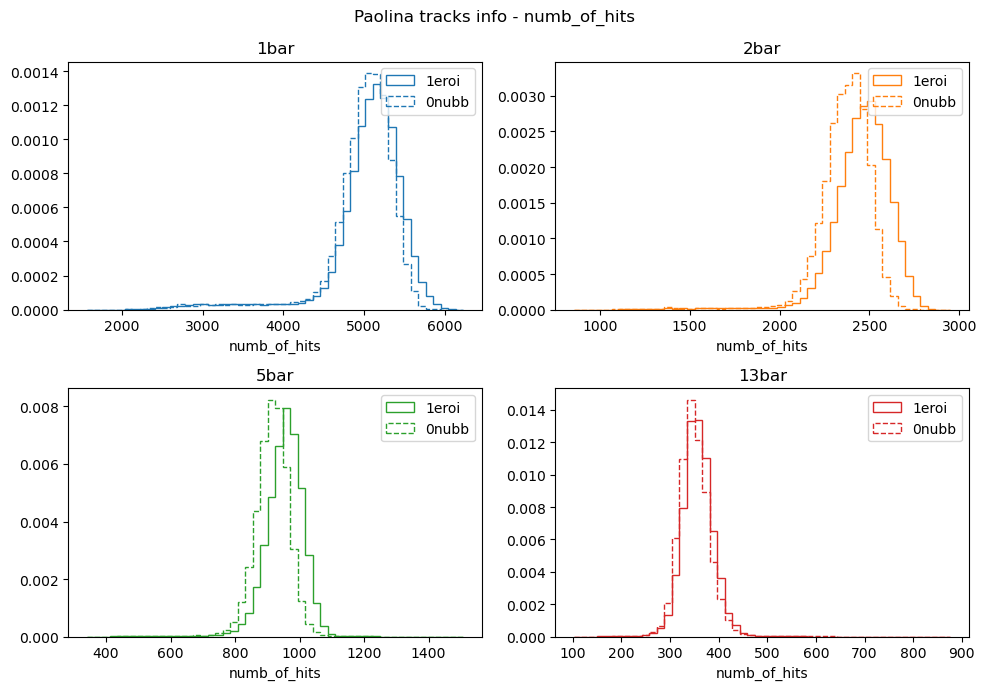

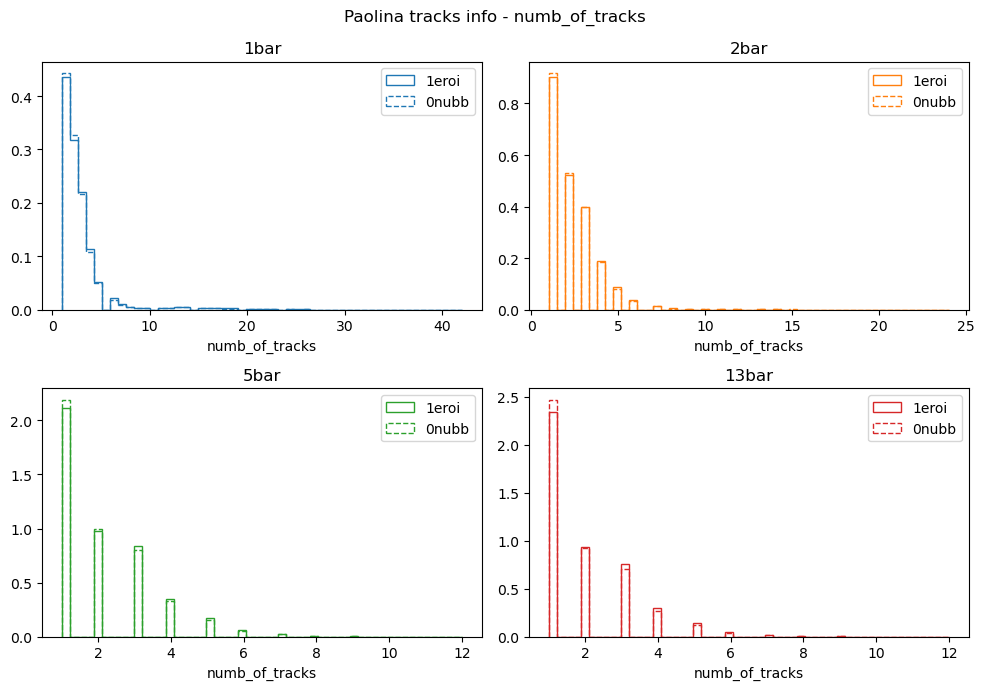

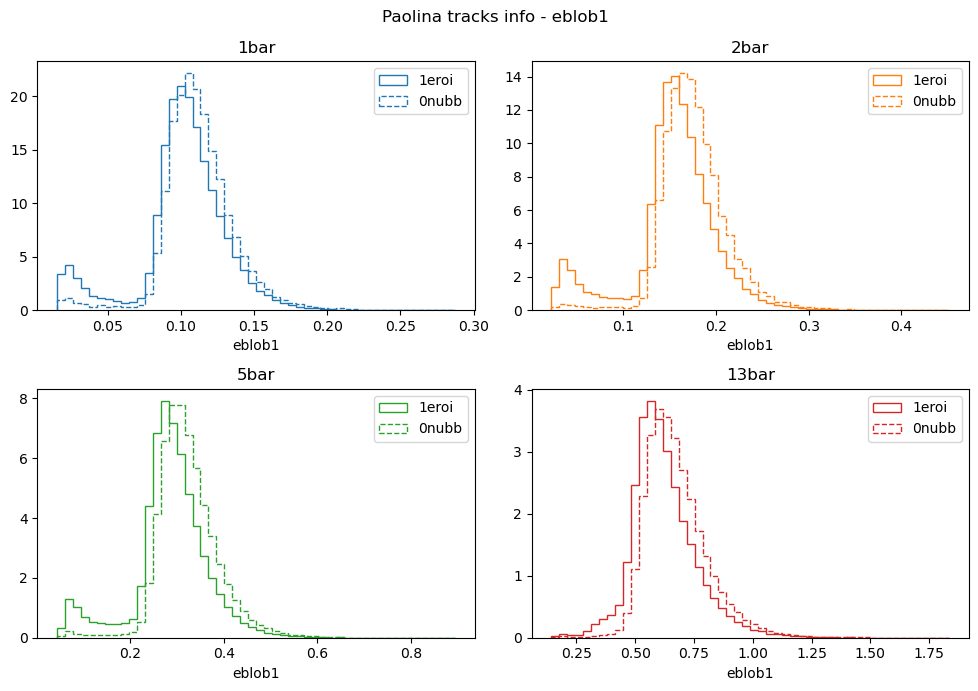

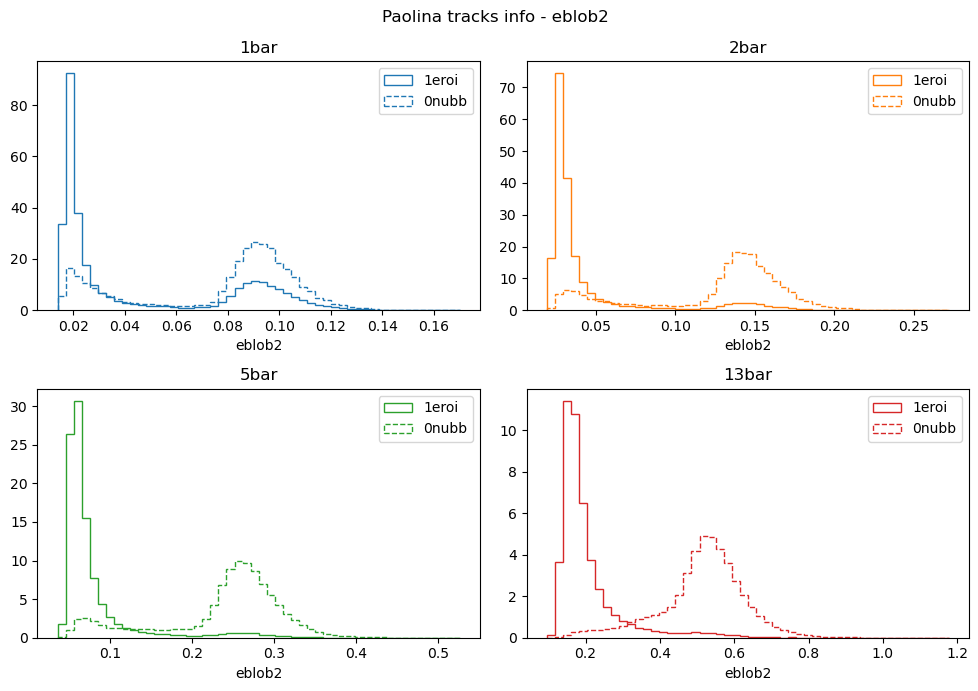

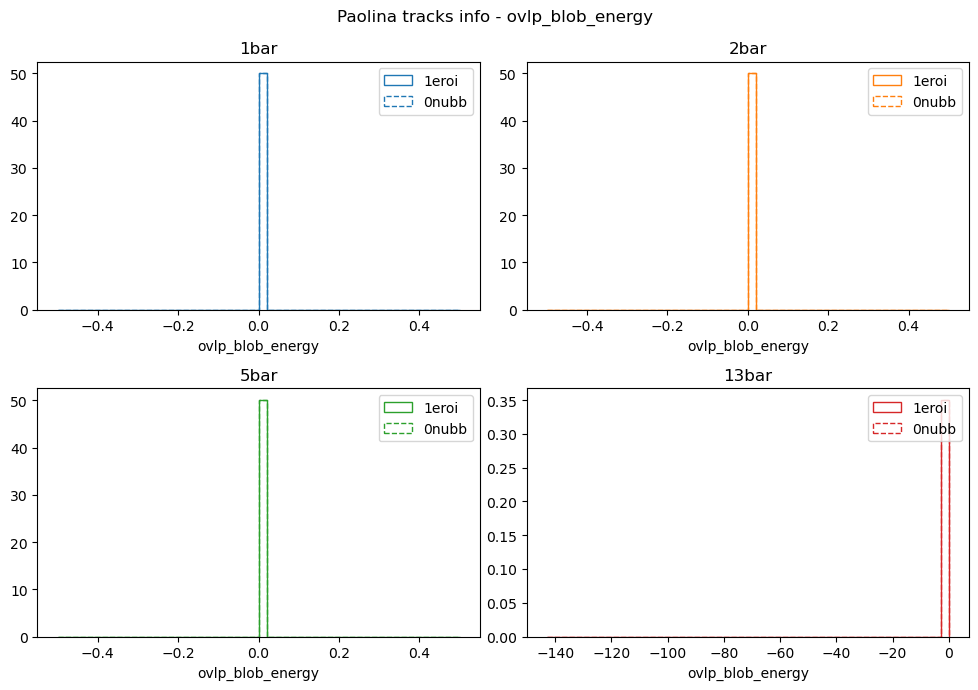

In [75]:
save_path = basedir + 'track_info_df.h5'

results_tracks_1eroi = pd.read_hdf(save_path, '1eroi')
results_tracks_0nubb = pd.read_hdf(save_path, '0nubb')

plot_dict = {'1bar':'tab:blue', '2bar':'tab:orange', '5bar':'tab:green', '13bar':'tab:red'}

for feature in ['energy', 'length', 'numb_of_voxels', 'numb_of_hits', 'numb_of_tracks', 'eblob1', 'eblob2', 'ovlp_blob_energy']:
    fig = plt.figure(figsize = (10, 7))
    fig.suptitle('Paolina tracks info - ' + feature)
    axes = fig.add_subplot(221), fig.add_subplot(222), fig.add_subplot(223), fig.add_subplot(224)
    for i, p in enumerate(pressures):
        plt.tight_layout()
        info_1eroi = results_tracks_1eroi[results_tracks_1eroi.pressure == p][feature]
        info_0nubb = results_tracks_0nubb[results_tracks_0nubb.pressure == p][feature]
        max_ = max(max(info_1eroi), max(info_0nubb))
        min_ = min(min(info_1eroi), min(info_0nubb))

        axes[i].hist(info_1eroi, 50, (min_, max_), color = plot_dict[p], ls = '-',  histtype='step', density = True, label = '1eroi')
        axes[i].hist(info_0nubb, 50, (min_, max_), color = plot_dict[p], ls = '--', histtype='step', density = True, label = '0nubb')
        axes[i].set_xlabel(feature)
        axes[i].set_title(p)
        if feature == 'energy':
            axes[i].set_yscale('log')
        axes[i].legend()
        #plt.show()


#### Plot eblob1 vs eblob2 for each P

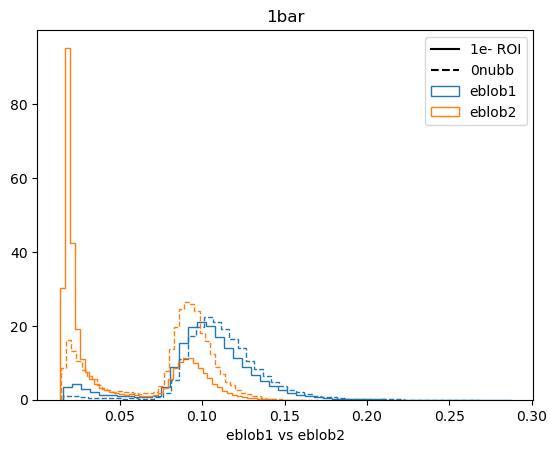

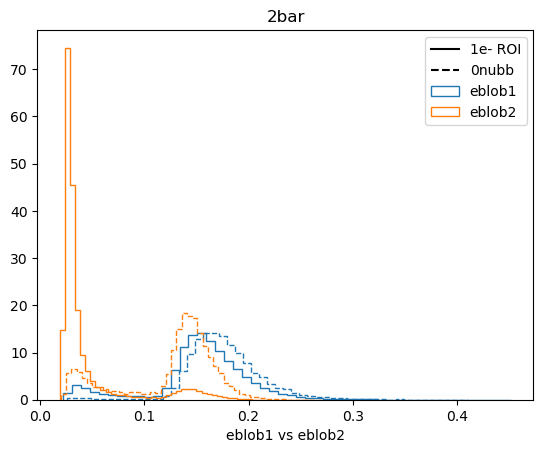

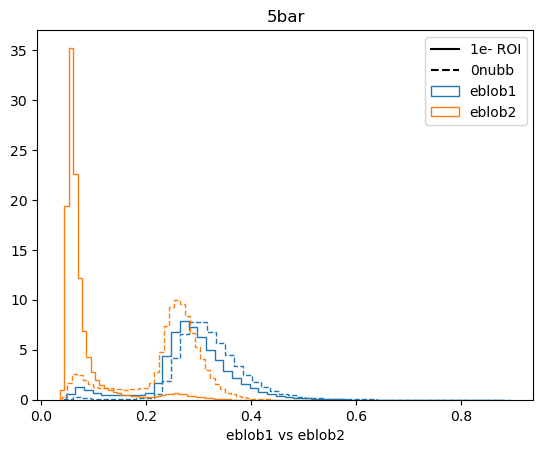

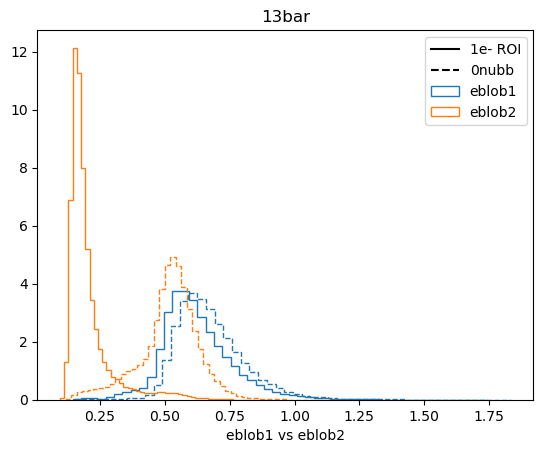

In [33]:
save_path = basedir + 'track_info_df.h5'

results_tracks_1eroi = pd.read_hdf(save_path, '1eroi')
results_tracks_0nubb = pd.read_hdf(save_path, '0nubb')

plot_dict = {'1bar':'tab:blue', '2bar':'tab:orange', '5bar':'tab:green', '13bar':'tab:red'}

for p in pressures:
    plt.figure()
    plt.hist(results_tracks_1eroi[results_tracks_1eroi.pressure == p]['eblob1'], 50, color = 'tab:blue', ls = '-',  histtype='step', density = True, label = 'eblob1')
    plt.hist(results_tracks_0nubb[results_tracks_0nubb.pressure == p]['eblob1'], 50, color = 'tab:blue', ls = '--', histtype='step', density = True)
    plt.hist(results_tracks_1eroi[results_tracks_1eroi.pressure == p]['eblob2'], 50, color = 'tab:orange', ls = '-',  histtype='step', density = True, label = 'eblob2')
    plt.hist(results_tracks_0nubb[results_tracks_0nubb.pressure == p]['eblob2'], 50, color = 'tab:orange', ls = '--', histtype='step', density = True)
    plt.xlabel('eblob1 vs eblob2')
    plt.title(p)
    plt.plot([], [], 'k-',  label="1e- ROI")
    plt.plot([], [], 'k--', label="0nubb")
    #plt.yscale('log')
    plt.legend()
    plt.show()

Lo importante es ver si la línea sólida (1eroi) naranja (blob2) se separa de la línea punteada (0nubb) naranja (blob2) ENTIENDO. Porque lo que quieres es escoger un corte en la variable blob2 (el blob pequeño, color naranja) que diferencie el tipo de datos (lineas punteadas vs lineas solidas)

#### Plot distance between MC and isaura extremes

Ahora vamos a ver lo bien que acierta isaura comparando con la info de MC

In [34]:
def swap_arrays_in_tuple(tupl, bin_arr):
    swapped = (
        np.where(bin_arr[:, None], tupl[1], tupl[0]),
        np.where(bin_arr[:, None], tupl[0], tupl[1])
    )
    return swapped

In [35]:
def get_mc_isa_extr_dist(track_info, label_hits, ext_type = 'extreme'):
    main_tr = track_info[track_info.trackID == 0]
    #get the extremes for mc and isaura, as a tuple of extreme 1 and 2
    mc_extreme = (np.array(list(label_hits.ext1.values)), np.array(list(label_hits.ext2.values)))
    is_extreme = (np.array([main_tr[ext_type + '1_x'].values, main_tr[ext_type + '1_y'].values, main_tr[ext_type + '1_z'].values]).T, np.array([main_tr[ext_type + '2_x'].values, main_tr[ext_type + '2_y'].values, main_tr[ext_type + '2_z'].values]).T)

    #do for the 2 combinations a metric (dist(mc1-isa1)**2 + dist(mc2-isa2)**2) VS (dist(mc1-isa2)**2 + dist(mc2-isa1)**2)
    comb1 = np.linalg.norm(mc_extreme[0] - is_extreme[0], axis = 1) **2 + np.linalg.norm(mc_extreme[1] - is_extreme[1], axis = 1) ** 2
    comb2 = np.linalg.norm(mc_extreme[0] - is_extreme[1], axis = 1) **2 + np.linalg.norm(mc_extreme[1] - is_extreme[0], axis = 1) ** 2

    #get positions where the metric is minimum
    min_dist = np.argmin(np.array([comb1, comb2]).T, axis = 1)

    #swipe positions to have for each event the combination that minimizes the metric
    new_is_extreme = swap_arrays_in_tuple(is_extreme, min_dist)

    #finally, with the correct combination, we can compute distances for both extreme1 and extreme2 without differenciation and get them
    dist_mc_isa_extrems = np.append(np.linalg.norm(mc_extreme[0] - new_is_extreme[0], axis = 1), np.linalg.norm(mc_extreme[1] - new_is_extreme[1], axis = 1))
    return dist_mc_isa_extrems

In [36]:
def get_extr_dist(file_dict, dt, label_hits_path, pressures = ['1bar', '2bar', '5bar', '13bar']):
    label_hits_all = pd.read_hdf(label_hits_path, dt)
    label_hits_all = label_hits_all[(label_hits_all.segclass == 1)]
    results = pd.DataFrame([])
    for p in pressures:
        print(p)
        for f in file_dict[p]:
            fnum = int(f.split('_')[-2])

            label_hits = label_hits_all[(label_hits_all.pressure == p) & (label_hits_all.filenum == fnum)].drop('segclass', axis = 1)
            track_info = pd.read_hdf(f, 'DATASET/IsauraMCInfo')
            event_info = pd.read_hdf(f, 'DATASET/EventsInfo')
            #select because with labelling some events are removed (the ones with z<0)
            track_info = track_info[np.isin(track_info.event, event_info.event_id)]

            dist_ext_df = pd.DataFrame(get_mc_isa_extr_dist(track_info, label_hits)).rename(columns={0:'ext_dist'})

            dist_ext_df.insert(len(dist_ext_df.columns), 'pressure', p)
            dist_ext_df.insert(len(dist_ext_df.columns), 'filenum', fnum)
            results = results.append(dist_ext_df)
    return results

In [37]:
save_path = basedir + 'track_extreme_info_df.h5'

# dt = '1eroi'
# nexusfiles, labelfiles, graphfiles = get_file_dict(basedir, dt)
# results = get_extr_dist(labelfiles, dt, basedir + 'label_hits_info_df.h5')
# results.to_hdf(save_path, dt)

# dt = '0nubb'
# nexusfiles, labelfiles, graphfiles = get_file_dict(basedir, dt)
# results = get_extr_dist(labelfiles, dt, basedir + 'label_hits_info_df.h5')
# results.to_hdf(save_path, dt)

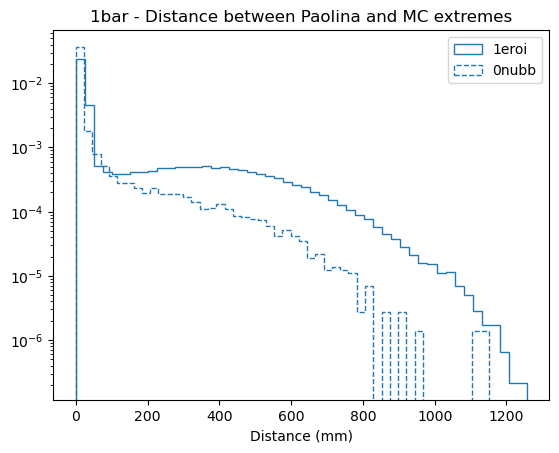

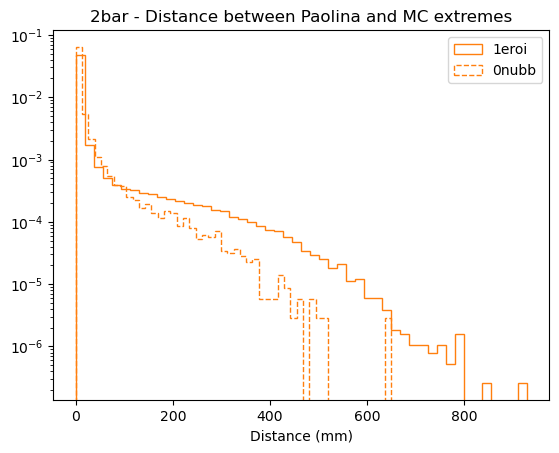

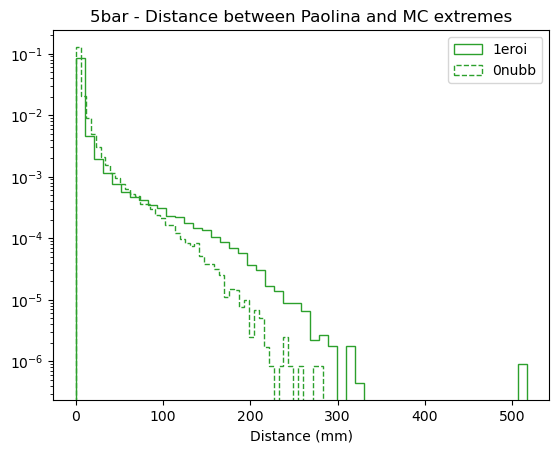

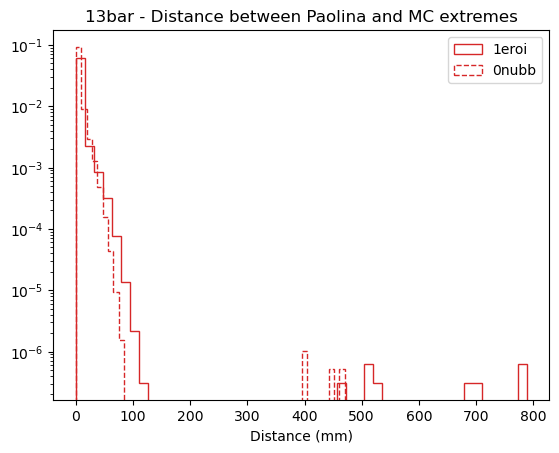

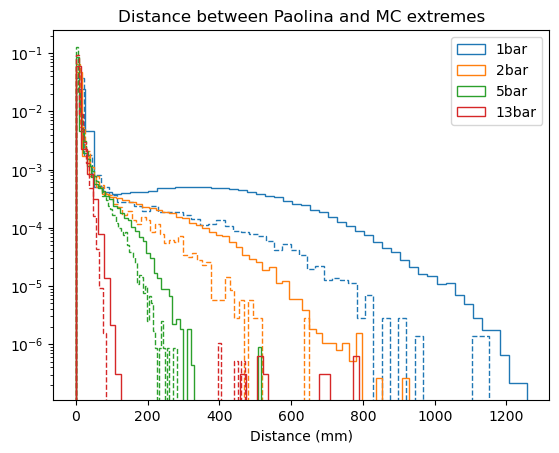

In [76]:
save_path = basedir + 'track_extreme_info_df.h5'

results_extr_1eroi = pd.read_hdf(save_path, '1eroi')
results_extr_0nubb = pd.read_hdf(save_path, '0nubb')

plot_dict = {'1bar':'tab:blue', '2bar':'tab:orange', '5bar':'tab:green', '13bar':'tab:red'}

for i, p in enumerate(pressures):
    plt.figure(i)
    plt.hist(results_extr_1eroi[results_extr_1eroi.pressure == p].ext_dist, 50, color = plot_dict[p], ls = '-',  histtype='step', density = True, label = '1eroi')
    plt.hist(results_extr_0nubb[results_extr_0nubb.pressure == p].ext_dist, 50, color = plot_dict[p], ls = '--', histtype='step', density = True, label = '0nubb')
    plt.xlabel('Distance (mm)')
    plt.title(p + ' - Distance between Paolina and MC extremes')
    plt.yscale('log')
    plt.legend()

    plt.figure(10)
    plt.hist(results_extr_1eroi[results_extr_1eroi.pressure == p].ext_dist, 50, color = plot_dict[p], ls = '-',  histtype='step', density = True, label = p)
    plt.hist(results_extr_0nubb[results_extr_0nubb.pressure == p].ext_dist, 50, color = plot_dict[p], ls = '--', histtype='step', density = True)
    plt.xlabel('Distance (mm)')
    plt.title('Distance between Paolina and MC extremes')
    plt.yscale('log')
plt.legend()

#### Explore blob radius on MC hits

In [7]:
def mc_blob_energy(mchits, label_hits, R):
    rename_dict = {'ext1_en':'blob1_en_{}mm'.format(R), 'ext2_en':'blob2_en_{}mm'.format(R)}
    #get the extremes of the track for each hit
    hits = mchits.merge(label_hits[['dataset_id', 'ext1', 'ext2']])

    #compute distances for each hit to the extreme and select the ones inside an spere of radius R
    hits['ext1_in'] = np.linalg.norm(np.array(list(hits.ext1.values)) - hits[['x', 'y', 'z']].values, axis = 1) < R
    hits['ext2_in'] = np.linalg.norm(np.array(list(hits.ext2.values)) - hits[['x', 'y', 'z']].values, axis = 1) < R

    #group the selected hits and sum their energy
    hits = hits.merge(hits[hits.ext1_in].groupby('dataset_id').sum().energy.rename('ext1_en'), on = 'dataset_id')
    hits = hits.merge(hits[hits.ext2_in].groupby('dataset_id').sum().energy.rename('ext2_en'), on = 'dataset_id')

    #search where the extreme 1 is not greater than the extreme 2 as it should, to order the blobs
    mask = hits.ext1_en < hits.ext2_en
    hits.loc[mask, ['ext1', 'ext2', 'ext1_in', 'ext2_in', 'ext1_en', 'ext2_en']] = hits.loc[mask, ['ext2', 'ext1', 'ext2_in', 'ext1_in', 'ext2_en', 'ext1_en']].values

    #transform to tuple to do the drop duplicates
    hits[['ext1', 'ext2']] = hits[['ext1', 'ext2']].applymap(tuple)

    new_label_hits = label_hits.drop(['ext1', 'ext2'], axis = 1).merge(hits[['dataset_id', 'ext1_en', 'ext2_en', 'ext1', 'ext2']].drop_duplicates().rename(columns=rename_dict), on = 'dataset_id')
    return new_label_hits

In [8]:
def get_mc_blob_energy(file_dict, dt, label_hits_path, blob_rad, pressures = ['1bar', '2bar', '5bar', '13bar']):
    label_hits_all = pd.read_hdf(label_hits_path, dt)
    label_hits_all = label_hits_all[(label_hits_all.segclass == 1)]
    results = pd.DataFrame([])
    for p in pressures:
        print(p)
        for f in file_dict[p]:
            fnum = int(f.split('_')[-2])

            label_hits = label_hits_all[(label_hits_all.pressure == p) & (label_hits_all.filenum == fnum)].drop('segclass', axis = 1)
            mchits  = pd.read_hdf(f, 'DATASET/MCHits')

            for R in blob_rad:
                label_hits = mc_blob_energy(mchits, label_hits, R)
            results = results.append(label_hits)
    return results

In [14]:
save_path = basedir + 'track_blobrad_info_df.h5'
blob_radius = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# dt = '1eroi'
# nexusfiles, labelfiles, graphfiles = get_file_dict(basedir, dt)
# results = get_mc_blob_energy(labelfiles, dt, basedir + 'label_hits_info_df.h5', blob_radius)
# results.to_hdf(save_path, dt)

# dt = '0nubb'
# nexusfiles, labelfiles, graphfiles = get_file_dict(basedir, dt)
# results = get_mc_blob_energy(labelfiles, dt, basedir + 'label_hits_info_df.h5', blob_radius)
# results.to_hdf(save_path, dt)

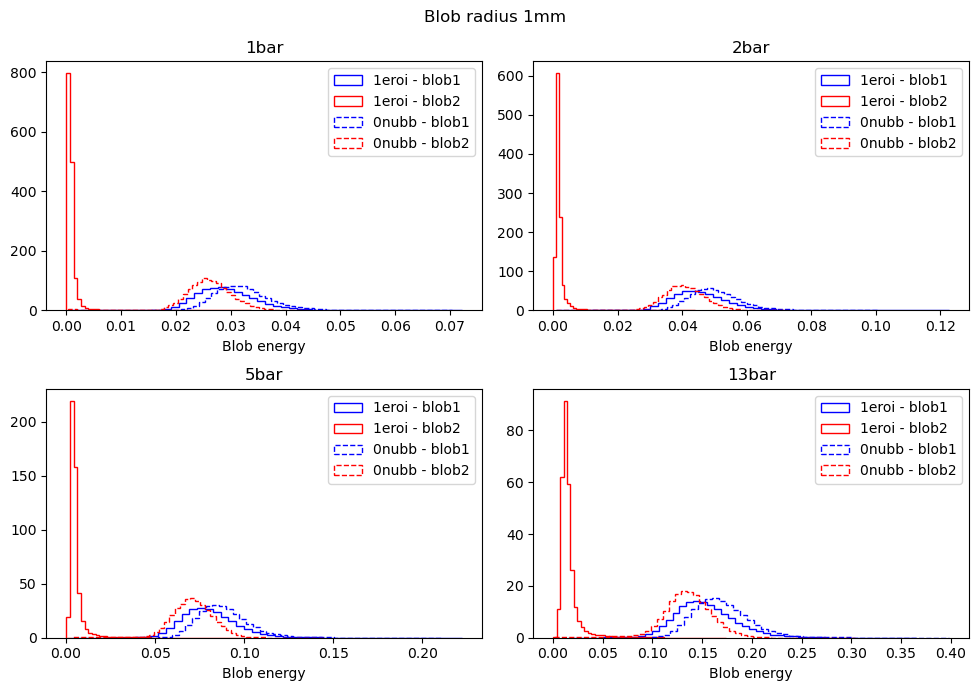

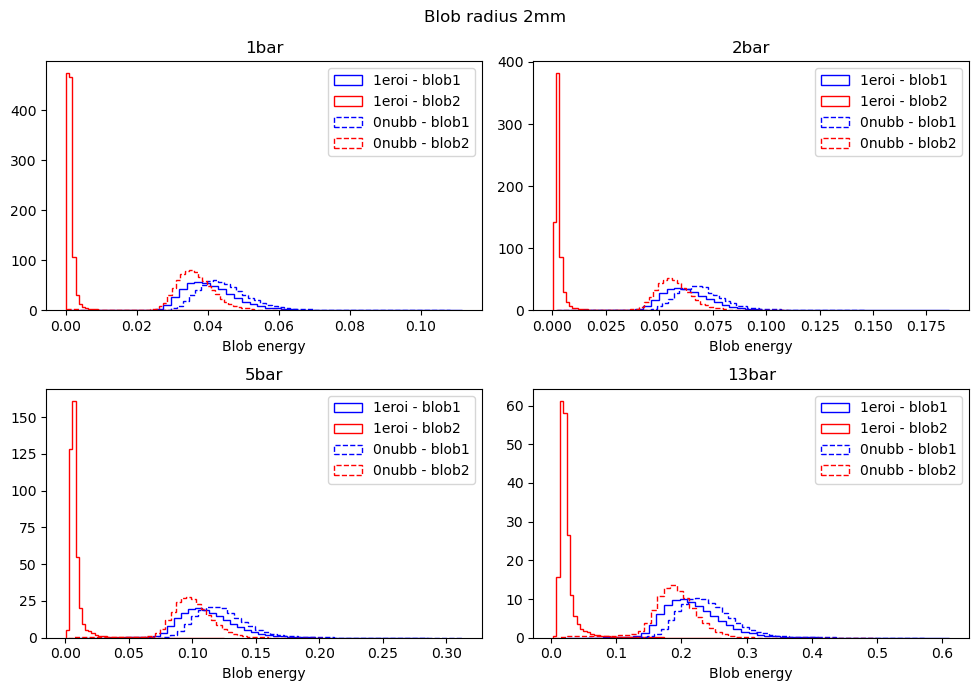

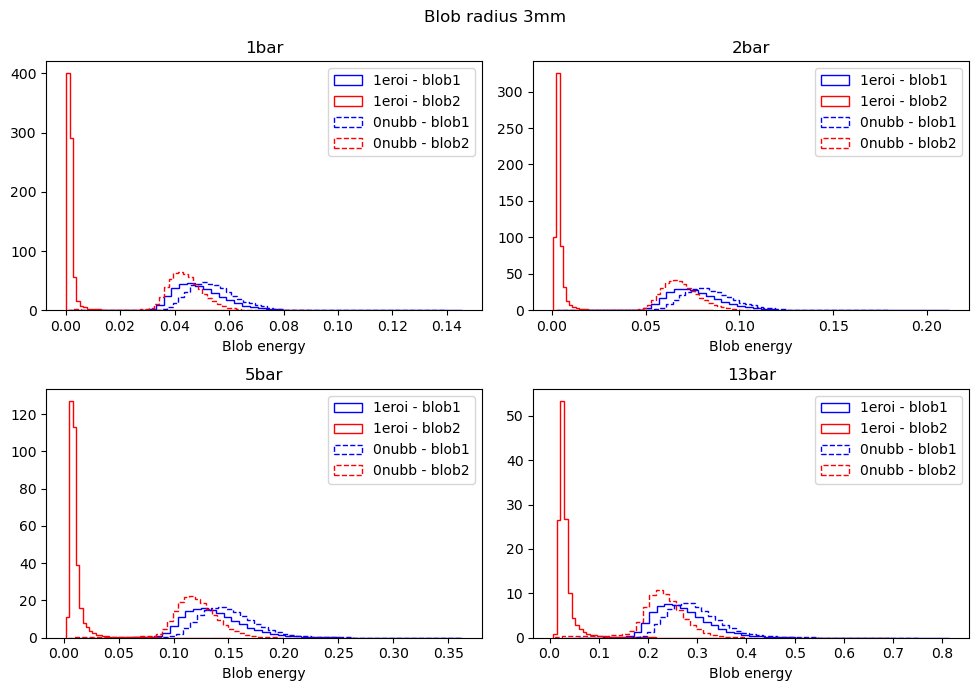

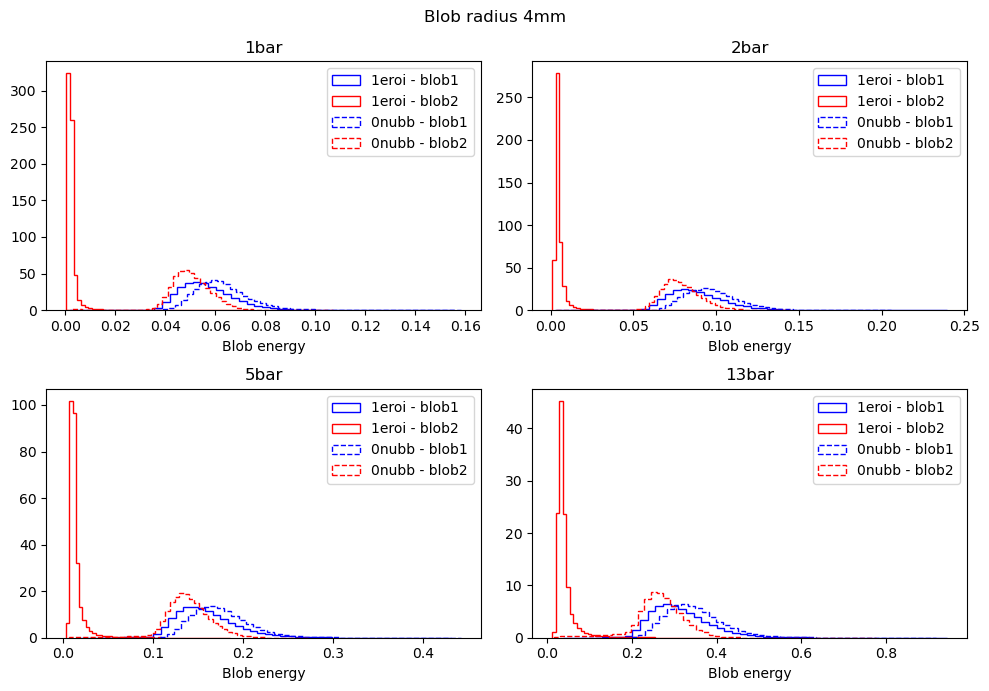

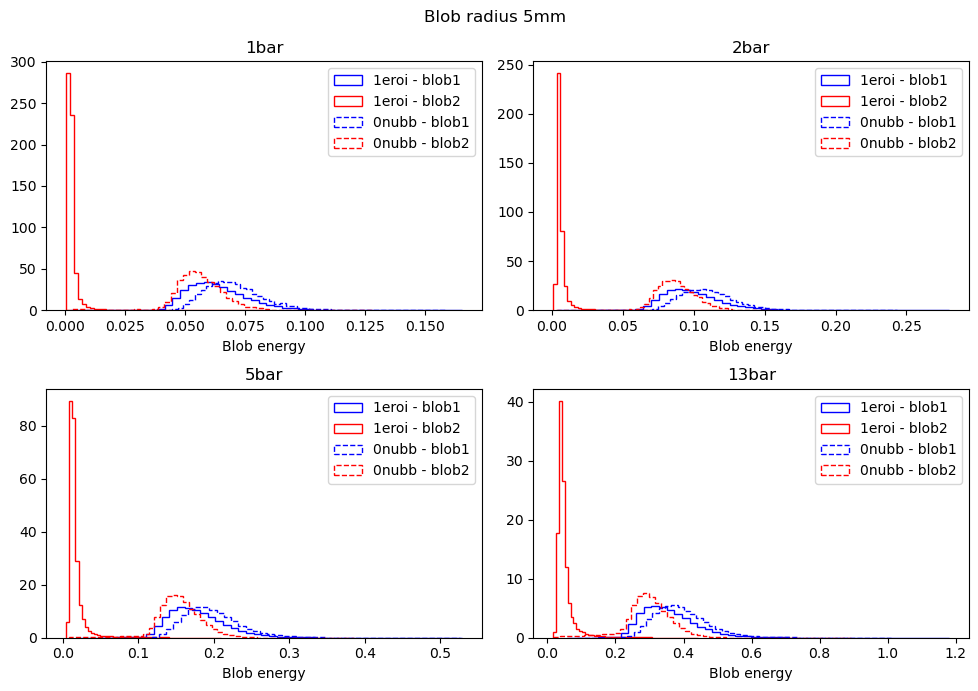

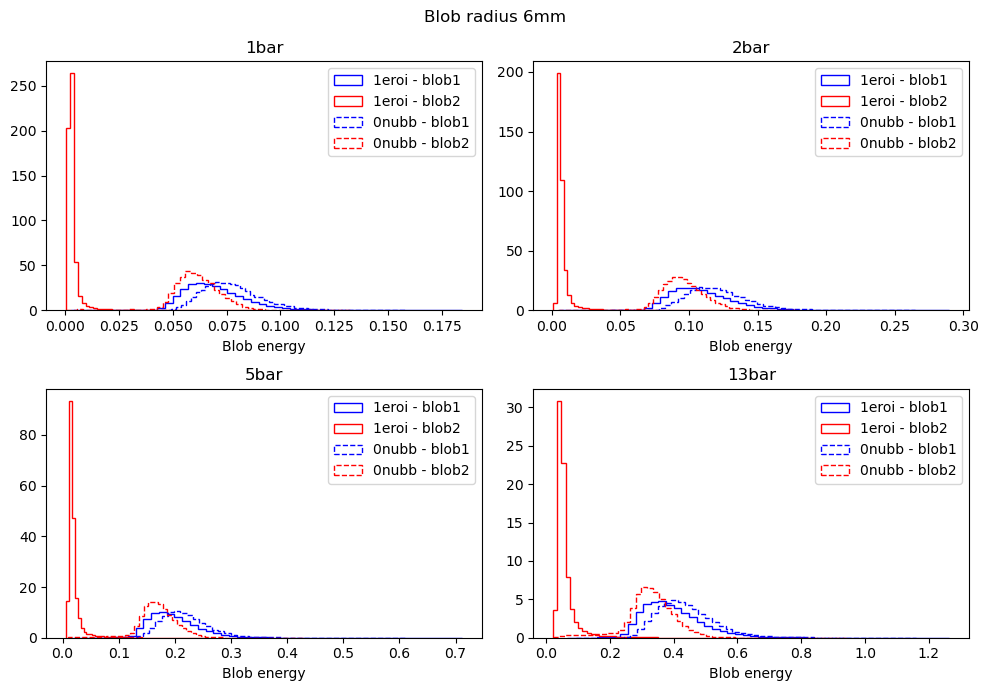

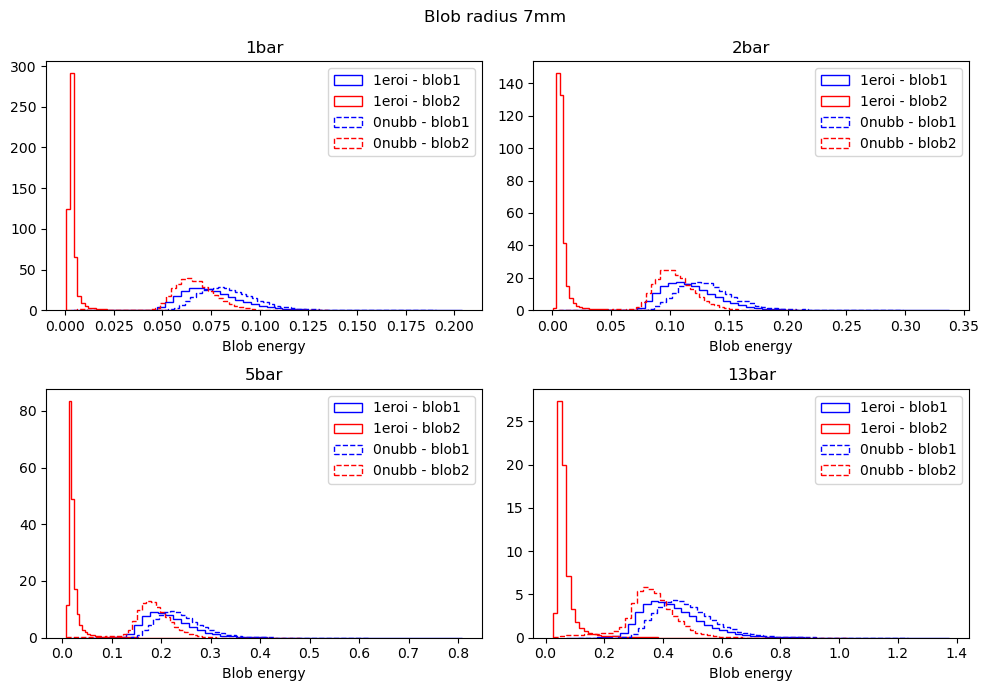

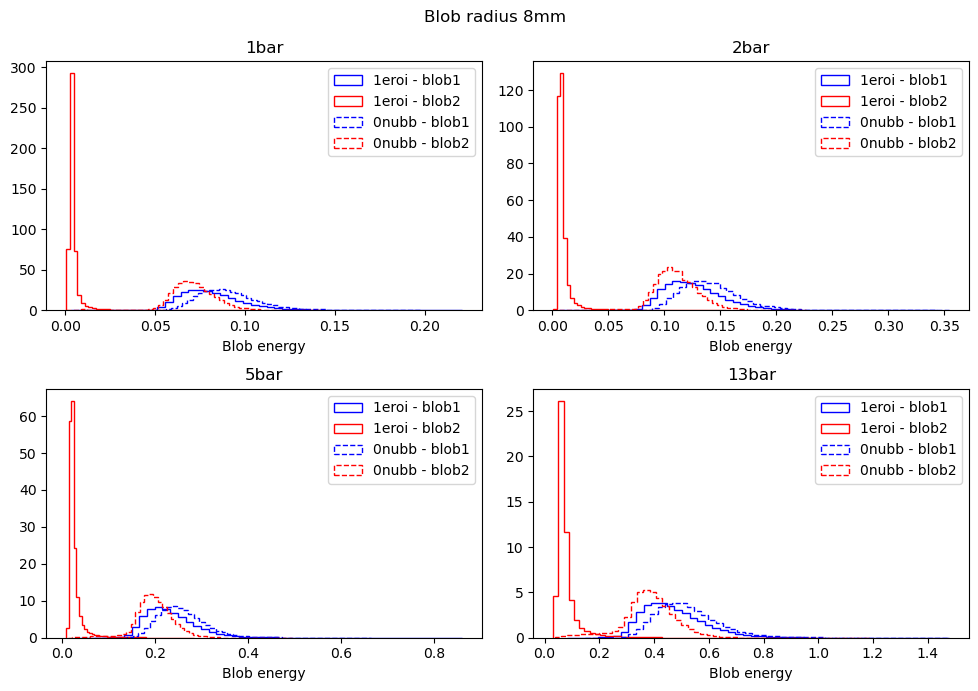

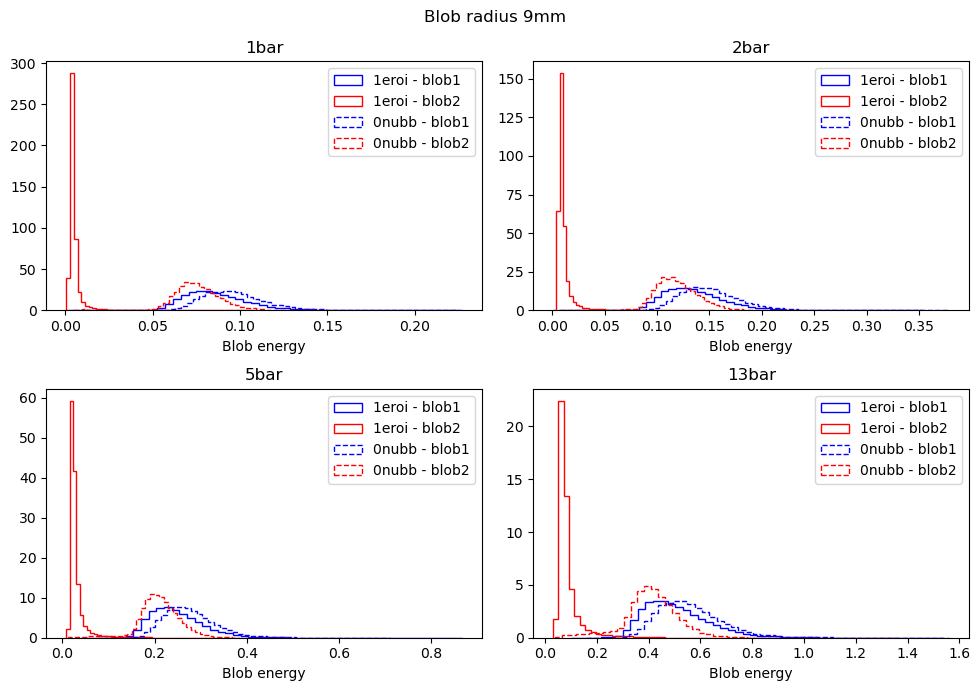

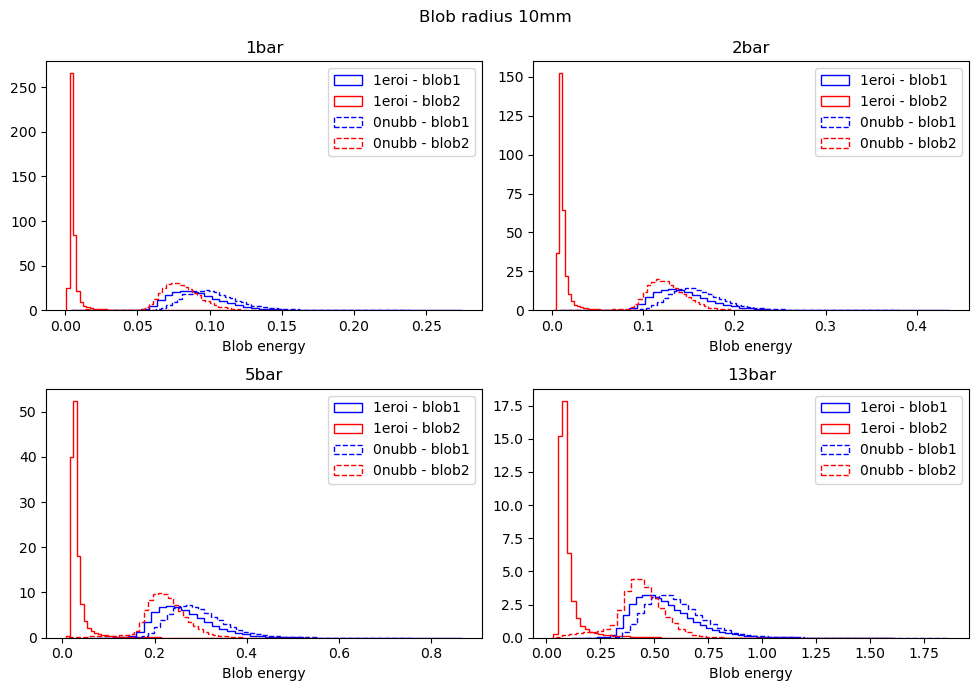

In [17]:
save_path = basedir + 'track_blobrad_info_df.h5'
blob_radius = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

results_tracks_1eroi = pd.read_hdf(save_path, '1eroi')
results_tracks_0nubb = pd.read_hdf(save_path, '0nubb')


for blobrad in blob_radius:
    fig = plt.figure(figsize = (10, 7))
    fig.suptitle('Blob radius {}mm'.format(blobrad))
    axes = fig.add_subplot(221), fig.add_subplot(222), fig.add_subplot(223), fig.add_subplot(224)
    for i, p in enumerate(pressures):
        plt.tight_layout()
        info_1eroi = results_tracks_1eroi[results_tracks_1eroi.pressure == p]
        info_0nubb = results_tracks_0nubb[results_tracks_0nubb.pressure == p]

        axes[i].hist(info_1eroi['blob1_en_{}mm'.format(blobrad)], 50, color = 'b', ls = '-',  histtype='step', density = True, label = '1eroi - blob1')
        axes[i].hist(info_1eroi['blob2_en_{}mm'.format(blobrad)], 50, color = 'r', ls = '-',  histtype='step', density = True, label = '1eroi - blob2')
        axes[i].hist(info_0nubb['blob1_en_{}mm'.format(blobrad)], 50, color = 'b', ls = '--', histtype='step', density = True, label = '0nubb - blob1')
        axes[i].hist(info_0nubb['blob2_en_{}mm'.format(blobrad)], 50, color = 'r', ls = '--', histtype='step', density = True, label = '0nubb - blob2')
        axes[i].set_xlabel('Blob energy')
        axes[i].set_title(p)
        axes[i].legend()
        #plt.show()

## GRAPH

In [18]:
import networkx as nx

In [33]:
def plot_graph_ener(graph, value, cmap = plt.cm.jet, nsize = 200, nodesep = 3):
    # To see the graph untangled I used this spring layout with some initial real positions and it seems to work
    pos   = nx.spring_layout(graph, k = nodesep, pos = {n:np.array([graph.nodes[n]['voxel'][1], graph.nodes[n]['voxel'][2]]) for n in graph.nodes})

    nodes = [graph.nodes[node][value] for node in graph]
    #now is hardcoded but is good I think
    label = [1 if graph.nodes[node]['segclass'] == 3 else 0 for node in graph]

    plt.figure(figsize = (10, 10))
    nx.draw(graph, pos, node_color=list(nodes), cmap=cmap, node_size=nsize, with_labels=True, font_size = 7, font_color = 'white')

    blob_nodes = [i for i, n in enumerate(label) if n != 0]
    nx.draw_networkx_nodes(graph, pos, nodelist=blob_nodes, node_color='none', edgecolors='black', node_size=nsize, linewidths=1.5)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(list(nodes)), vmax=max(list(nodes))))
    sm.set_array([])  # An empty array is required for ScalarMappable
    # Generate a legend with the marker and label
    legend_marker = plt.Line2D([], [], marker='o', color='white', markersize=10, markeredgewidth=1, markeredgecolor='black', label='Blob label')
    # Add the legend to the plot
    plt.legend(handles=[legend_marker])
    # Add a colorbar
    plt.colorbar(sm, label='Energy')
    plt.title('Node energy graph')
    plt.show()

In [31]:
p = '13bar'
dt = '1eroi'
n = 0

nexusfiles, labelfiles, graphfiles = get_file_dict(basedir, dt)
label_file = labelfiles[p][n]
graph_file = graphfiles[p][n]

event = 0
voxel_df = pd.read_hdf(label_file, 'DATASET/MCVoxels')
voxel = voxel_df[voxel_df.dataset_id == event]
graph = nx.read_gpickle(graph_file)[event]
bins_info = pd.read_hdf(label_file, 'DATASET/BinsInfo')


/scratch/6272294/ipykernel_798161/1142566156.py:160: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels[0])
/scratch/6272294/ipykernel_798161/1142566156.py:162: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels[1])
/scratch/6272294/ipykernel_798161/1142566156.py:164: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_zticklabels(labels[2])


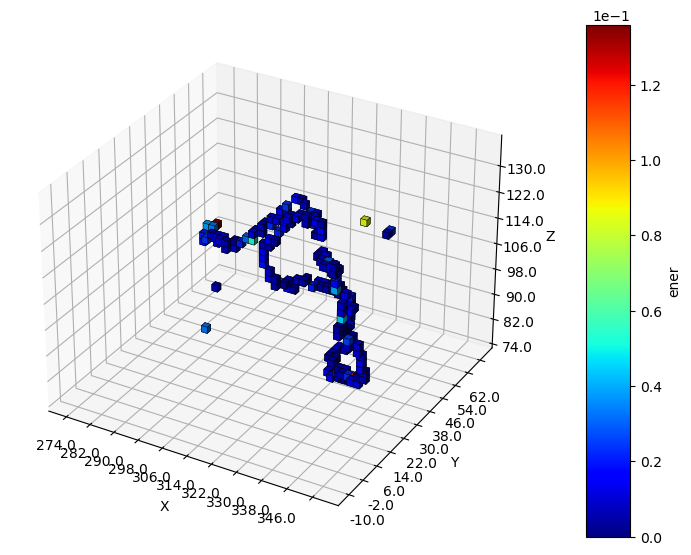

In [32]:
plot_3d_vox (voxel, (2, 2, 2), 'ener', bins_info, affluence = (4, 4, 4))

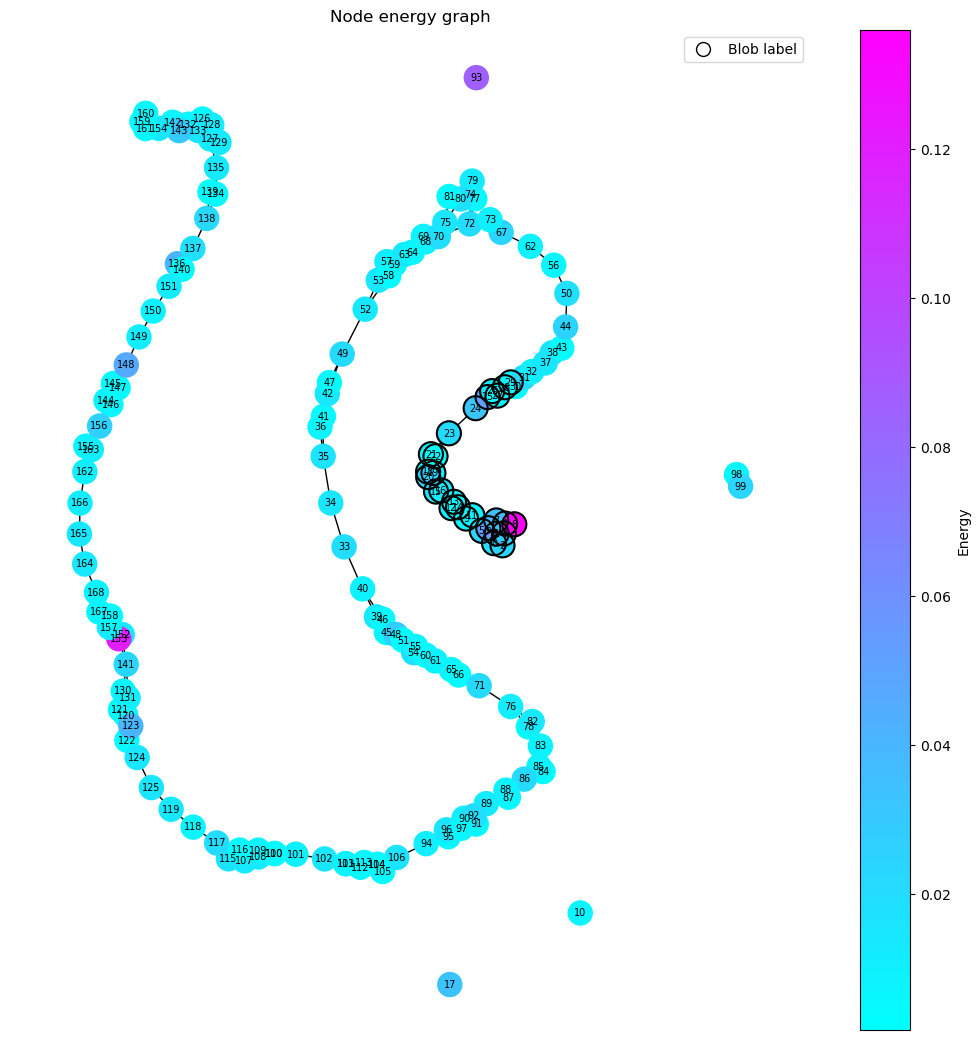

In [39]:
plot_graph_ener(graph, 'ener', nsize = 300, nodesep = 3)

#### Assortativity

In [153]:
nx.attribute_assortativity_coefficient(graph, "voxel")

-0.0076597038754680396

In [154]:
nx.numeric_assortativity_coefficient(graph, "ener")

0.12068199955568981

In [155]:
nx.numeric_assortativity_coefficient(graph, "segclass")

0.8957155687041055

In [156]:
nx.numeric_assortativity_coefficient(graph, "nhits")

-0.026254546943566378

In [157]:
nx.degree_assortativity_coefficient(graph)

0.6745328929523076

In [158]:
from networkx.algorithms import approximation as app

#### Connectivity

In [159]:
connectivity = app.all_pairs_node_connectivity(graph)

In [160]:
app.k_components(graph)[4]

[{112, 113, 115, 116, 125},
 {126, 127, 134, 136, 137},
 {106, 107, 117, 118, 119, 120, 129}]

Para k components puedo mirar cual es el tamaño maximo de k components (su ultima key del diccionario) y cuantos grupos tiene para esa key.....

#### Clique: grupo de nodos que están todos conectados entre todos

Podemos mirar quizás cuales son los mayores cliques para ver que tamaño tienen... o algo así

Quizás puedo mirar pues todos los cliques dentro de un evento que tamaño tienen y decir ah pues esta es la distribución de cliques en mi evento o algo así

In [94]:
# sorted(list(nx.find_cliques(graph)), key = len, reverse = True)

#### Clustering

In [95]:
nx.average_clustering(graph)

0.5335916220531608

#### Distance measures

Mide el diametro; como no funciona si hay elementos desconectados, tenemos que hacerlo con subgraphs

In [96]:
subgraph = []
for component in nx.connected_components(graph):
    sg = graph.subgraph(component)
    subgraph.append(sg)
    print(nx.diameter(sg))
    

86
0
0
0
1


Puedo mirar tb el numero de subgraphs que hay aunque bueno, tampoco es que sea algo muy nuevo pq ya sabemos lo que es

Vemos que hay la larga con un diametro que entiendo que es el camino más largo de todos los caminos más cortos entre dos nodos de un grafo (lo mismo que mira Paolina no?)

#### Bridges: son los edges que no pertenecen a ningún cycle (es decir, que si los eliminamos el número de componentes conectadas del grafo incrementa)

Podemos mirar el numero de estos bichos que hay por ej

In [169]:
len(list(nx.bridges(graph)))


25

#### Centrality of the node

Calcula el grado del nodo / (nº de nodos total - 1)

Quizás algo se puede hacer

In [187]:
nx.degree_centrality(graph)

{0: 0.02976190476190476,
 1: 0.041666666666666664,
 2: 0.023809523809523808,
 3: 0.041666666666666664,
 4: 0.02976190476190476,
 5: 0.02976190476190476,
 6: 0.05357142857142857,
 7: 0.03571428571428571,
 8: 0.017857142857142856,
 9: 0.03571428571428571,
 10: 0.0,
 11: 0.041666666666666664,
 12: 0.03571428571428571,
 13: 0.03571428571428571,
 14: 0.02976190476190476,
 15: 0.03571428571428571,
 16: 0.041666666666666664,
 17: 0.0,
 18: 0.03571428571428571,
 19: 0.03571428571428571,
 20: 0.03571428571428571,
 21: 0.02976190476190476,
 22: 0.02976190476190476,
 23: 0.017857142857142856,
 24: 0.023809523809523808,
 25: 0.023809523809523808,
 26: 0.02976190476190476,
 27: 0.03571428571428571,
 28: 0.03571428571428571,
 29: 0.03571428571428571,
 30: 0.02976190476190476,
 31: 0.02976190476190476,
 32: 0.02976190476190476,
 33: 0.011904761904761904,
 34: 0.011904761904761904,
 35: 0.017857142857142856,
 36: 0.017857142857142856,
 37: 0.023809523809523808,
 38: 0.023809523809523808,
 39: 0.023809

#### Eigenvector centrality

Esto puede ser más interesante porque tiene en cuenta los valores de centralidad de sus vecinos, entiendo que te da un valor más alto cuanto más centrales sean tus vecinos, entonces...

Incluso puedo weightear con algo (por ej la energía, tendría sentido) y ver qué sale... Buino, parece que el weight tiene que ser de los edges rollo una "fuerza" de conexión... Puedo probar con la inversa de la distancia para que así los más lejanos tengan menos influencia... Pero no con las energías; quizás sí con el gradiente, no es mala idea...

In [200]:
nx.eigenvector_centrality(graph, max_iter = 1000)

{0: 0.22816645746120987,
 1: 0.29654034864765344,
 2: 0.19450740181327358,
 3: 0.28072473856126756,
 4: 0.2208577278161624,
 5: 0.2376375585242335,
 6: 0.37332268825778636,
 7: 0.2618757265921064,
 8: 0.12597880591391206,
 9: 0.25249634156192274,
 10: 2.494824779424217e-63,
 11: 0.2895882331059097,
 12: 0.2178623938086015,
 13: 0.2178623938086015,
 14: 0.19385591091903293,
 15: 0.16947641492318644,
 16: 0.1969352601848381,
 17: 2.494824779424217e-63,
 18: 0.13143577281535915,
 19: 0.13143577281535915,
 20: 0.13143577281535915,
 21: 0.08357632801237096,
 22: 0.08357632801237096,
 23: 0.02854023994110202,
 24: 0.005781836314754811,
 25: 0.00197175688498609,
 26: 0.002178082831389471,
 27: 0.0023406670237560785,
 28: 0.001642995289329385,
 29: 0.0014555831360967037,
 30: 0.0011469290057629282,
 31: 0.0008566258995735879,
 32: 0.0006488265409189539,
 33: 2.0918281413480873e-08,
 34: 6.362175414329288e-09,
 35: 1.027100869459794e-08,
 36: 1.822798318646927e-08,
 37: 0.00029194822233415406,


In [210]:
dct = nx.eigenvector_centrality(graph, max_iter = 1000)

sorted(dct, key=lambda x: dct[x], reverse=True)

[6,
 1,
 11,
 3,
 7,
 9,
 5,
 0,
 4,
 12,
 13,
 16,
 2,
 14,
 15,
 18,
 19,
 20,
 8,
 21,
 22,
 23,
 24,
 27,
 26,
 25,
 28,
 29,
 30,
 31,
 32,
 37,
 38,
 43,
 44,
 50,
 64,
 63,
 68,
 69,
 58,
 59,
 70,
 75,
 57,
 53,
 56,
 72,
 52,
 80,
 74,
 77,
 81,
 79,
 51,
 48,
 67,
 54,
 55,
 73,
 62,
 60,
 46,
 45,
 61,
 39,
 49,
 65,
 40,
 66,
 42,
 47,
 71,
 41,
 33,
 36,
 113,
 104,
 114,
 112,
 76,
 35,
 105,
 103,
 111,
 106,
 34,
 102,
 78,
 82,
 90,
 94,
 97,
 95,
 96,
 91,
 92,
 89,
 83,
 101,
 87,
 88,
 110,
 100,
 108,
 109,
 84,
 85,
 86,
 116,
 107,
 115,
 117,
 131,
 120,
 123,
 121,
 130,
 141,
 122,
 118,
 152,
 153,
 124,
 158,
 157,
 167,
 168,
 119,
 125,
 133,
 127,
 126,
 128,
 132,
 143,
 129,
 164,
 135,
 142,
 154,
 159,
 160,
 161,
 134,
 139,
 165,
 138,
 137,
 166,
 140,
 136,
 162,
 151,
 144,
 146,
 156,
 145,
 147,
 155,
 163,
 148,
 150,
 149,
 98,
 99,
 10,
 17,
 93]

#### Katz centrality

Hace parecido pero con parametros ajustables; beta puede ser como el "peso" de cada nodo ahora, así que se puede probar tb

In [217]:
nx.katz_centrality(graph, max_iter = 1000)

{0: 0.09944032842142117,
 1: 0.11839368438936758,
 2: 0.09018873023397492,
 3: 0.11598822663159589,
 4: 0.09874925784647458,
 5: 0.10176780759849303,
 6: 0.13946448221368946,
 7: 0.10973811741715041,
 8: 0.0753076643861967,
 9: 0.11090156542299032,
 10: 0.04286018880786325,
 11: 0.12087773522144289,
 12: 0.10936331276024457,
 13: 0.10936331276024457,
 14: 0.09957884236286507,
 15: 0.10762934425765837,
 16: 0.11668194901992861,
 17: 0.04286018880786325,
 18: 0.10409472518405928,
 19: 0.10409472518405928,
 20: 0.10409472518405928,
 21: 0.08992277941663118,
 22: 0.08992277941663118,
 23: 0.06841955293966388,
 24: 0.07574829147200622,
 25: 0.07826834188316886,
 26: 0.0870603445182431,
 27: 0.09513284028937885,
 28: 0.09614008290432141,
 29: 0.09671203404244588,
 30: 0.08879745773770904,
 31: 0.08682795603554307,
 32: 0.08455980296464508,
 33: 0.05471948283384696,
 34: 0.054473857056774586,
 35: 0.061417199772192704,
 36: 0.06269313623992416,
 37: 0.07346831726577256,
 38: 0.071190394881164

In [216]:
dct = nx.katz_centrality(graph, max_iter = 1000)

sorted(dct, key=lambda x: dct[x], reverse=True)

[6,
 11,
 1,
 16,
 3,
 9,
 7,
 12,
 13,
 15,
 18,
 19,
 20,
 5,
 14,
 0,
 4,
 64,
 29,
 63,
 28,
 27,
 51,
 48,
 58,
 75,
 113,
 2,
 21,
 22,
 68,
 69,
 90,
 30,
 70,
 72,
 54,
 55,
 26,
 31,
 59,
 60,
 32,
 104,
 114,
 112,
 46,
 61,
 97,
 131,
 108,
 109,
 120,
 133,
 89,
 80,
 123,
 116,
 127,
 25,
 57,
 45,
 158,
 105,
 24,
 154,
 91,
 92,
 8,
 53,
 39,
 121,
 103,
 111,
 95,
 96,
 106,
 130,
 37,
 74,
 77,
 107,
 126,
 141,
 100,
 110,
 128,
 65,
 152,
 153,
 143,
 132,
 157,
 38,
 144,
 146,
 145,
 147,
 135,
 156,
 42,
 23,
 41,
 86,
 83,
 52,
 79,
 122,
 94,
 129,
 142,
 66,
 115,
 40,
 87,
 88,
 102,
 167,
 101,
 43,
 159,
 160,
 161,
 67,
 47,
 84,
 85,
 124,
 71,
 36,
 117,
 49,
 168,
 148,
 134,
 139,
 155,
 163,
 78,
 82,
 44,
 76,
 138,
 35,
 137,
 136,
 140,
 162,
 151,
 81,
 73,
 33,
 149,
 62,
 125,
 118,
 164,
 34,
 50,
 150,
 166,
 119,
 56,
 165,
 98,
 99,
 10,
 17,
 93]

Asi cambian algo las tornas... ese 153 puede ser un other supongo que está por ahí por la traza...

In [227]:
dct = nx.katz_centrality(graph, beta = {node: graph.nodes[node]['ener'] for node in graph}, max_iter = 1000)

sorted(dct, key=lambda x: dct[x], reverse=True)

[8,
 153,
 6,
 3,
 7,
 4,
 93,
 1,
 25,
 0,
 2,
 5,
 148,
 123,
 11,
 24,
 136,
 141,
 48,
 20,
 143,
 9,
 152,
 17,
 31,
 72,
 157,
 16,
 156,
 70,
 26,
 12,
 44,
 67,
 13,
 23,
 75,
 15,
 54,
 92,
 80,
 138,
 137,
 49,
 133,
 158,
 86,
 38,
 63,
 28,
 99,
 71,
 131,
 117,
 90,
 14,
 27,
 124,
 19,
 96,
 33,
 32,
 29,
 37,
 18,
 50,
 106,
 21,
 89,
 154,
 115,
 53,
 39,
 35,
 42,
 69,
 127,
 64,
 68,
 135,
 108,
 52,
 107,
 57,
 125,
 128,
 55,
 151,
 102,
 34,
 129,
 104,
 120,
 79,
 165,
 97,
 30,
 149,
 132,
 51,
 119,
 94,
 82,
 61,
 164,
 130,
 73,
 58,
 163,
 111,
 76,
 46,
 103,
 144,
 59,
 40,
 22,
 45,
 113,
 121,
 91,
 142,
 77,
 95,
 166,
 147,
 109,
 112,
 88,
 168,
 145,
 162,
 65,
 146,
 116,
 101,
 140,
 155,
 167,
 62,
 85,
 36,
 114,
 122,
 83,
 60,
 126,
 150,
 74,
 41,
 134,
 43,
 87,
 118,
 81,
 47,
 100,
 160,
 110,
 56,
 78,
 159,
 161,
 105,
 66,
 98,
 84,
 139,
 10]

#### Closeness centrality

Sirve para saber un poco cual es el nodo más cercano al resto de nodos, le puedo poner como distancia la distancia real entre nodos :)


In [233]:
dct = nx.closeness_centrality(graph, distance='distance')

sorted(dct, key=lambda x: dct[x], reverse=True)

[83,
 84,
 78,
 82,
 86,
 85,
 76,
 88,
 87,
 71,
 89,
 65,
 66,
 90,
 61,
 60,
 55,
 96,
 95,
 92,
 91,
 51,
 94,
 48,
 97,
 54,
 106,
 46,
 39,
 105,
 45,
 40,
 104,
 114,
 113,
 33,
 112,
 34,
 111,
 103,
 35,
 102,
 36,
 41,
 101,
 42,
 100,
 47,
 110,
 49,
 109,
 108,
 52,
 116,
 107,
 58,
 53,
 115,
 117,
 59,
 64,
 63,
 118,
 57,
 69,
 119,
 70,
 68,
 125,
 72,
 75,
 124,
 73,
 67,
 81,
 122,
 123,
 77,
 80,
 74,
 62,
 120,
 131,
 121,
 79,
 56,
 130,
 141,
 50,
 153,
 152,
 44,
 157,
 158,
 43,
 167,
 38,
 168,
 37,
 164,
 32,
 165,
 31,
 30,
 166,
 29,
 28,
 162,
 27,
 26,
 163,
 155,
 25,
 24,
 156,
 23,
 146,
 144,
 22,
 147,
 21,
 145,
 148,
 19,
 20,
 18,
 149,
 15,
 16,
 150,
 13,
 12,
 151,
 14,
 9,
 11,
 140,
 136,
 5,
 6,
 137,
 7,
 1,
 138,
 3,
 0,
 4,
 2,
 8,
 139,
 134,
 135,
 129,
 127,
 128,
 126,
 133,
 132,
 143,
 142,
 154,
 161,
 159,
 160,
 98,
 99,
 10,
 17,
 93]

#### Cyles